In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importing Libraries

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import warnings 

warnings.filterwarnings('ignore')

<ipython-input-2-eac46b6e00ac>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Reading Data

In [3]:
df_rfm=pd.read_csv('/content/drive/MyDrive/Datasets/preprocessed_customer_supermarket_rfm.csv',index_col='CustomerID')
df_rfm.head()

Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          2           0.00
12347.0           3        151        3598.21
12348.0          76         31        1797.24
12349.0          19         73        1757.55
12350.0         311         17         334.40

# Data Pre-Processing for Clustering

K-Means assume symmertical distribution of varibles and variables have equal average value and std.

If the distribution is not symmetrical
Log transformation (if all values are positive)
Add the absolute value of the lowest negative value to each observation, and then with a small constant (e.g. 1) to force all variables to be positive
Use a cube root transformation
If the mean and variables are not equal, the variables could be standardised

* Reducing Skewness

In [4]:
def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return 

Recency's: Skew: 1.2444937290057807, : SkewtestResult(statistic=26.458726592189453, pvalue=2.895613835933345e-154)
Frequency's: Skew: 18.12183686440274, : SkewtestResult(statistic=83.17480537059672, pvalue=0.0)
MonetaryValue's: Skew: 21.459150114624148, : SkewtestResult(statistic=86.8803096286766, pvalue=0.0)


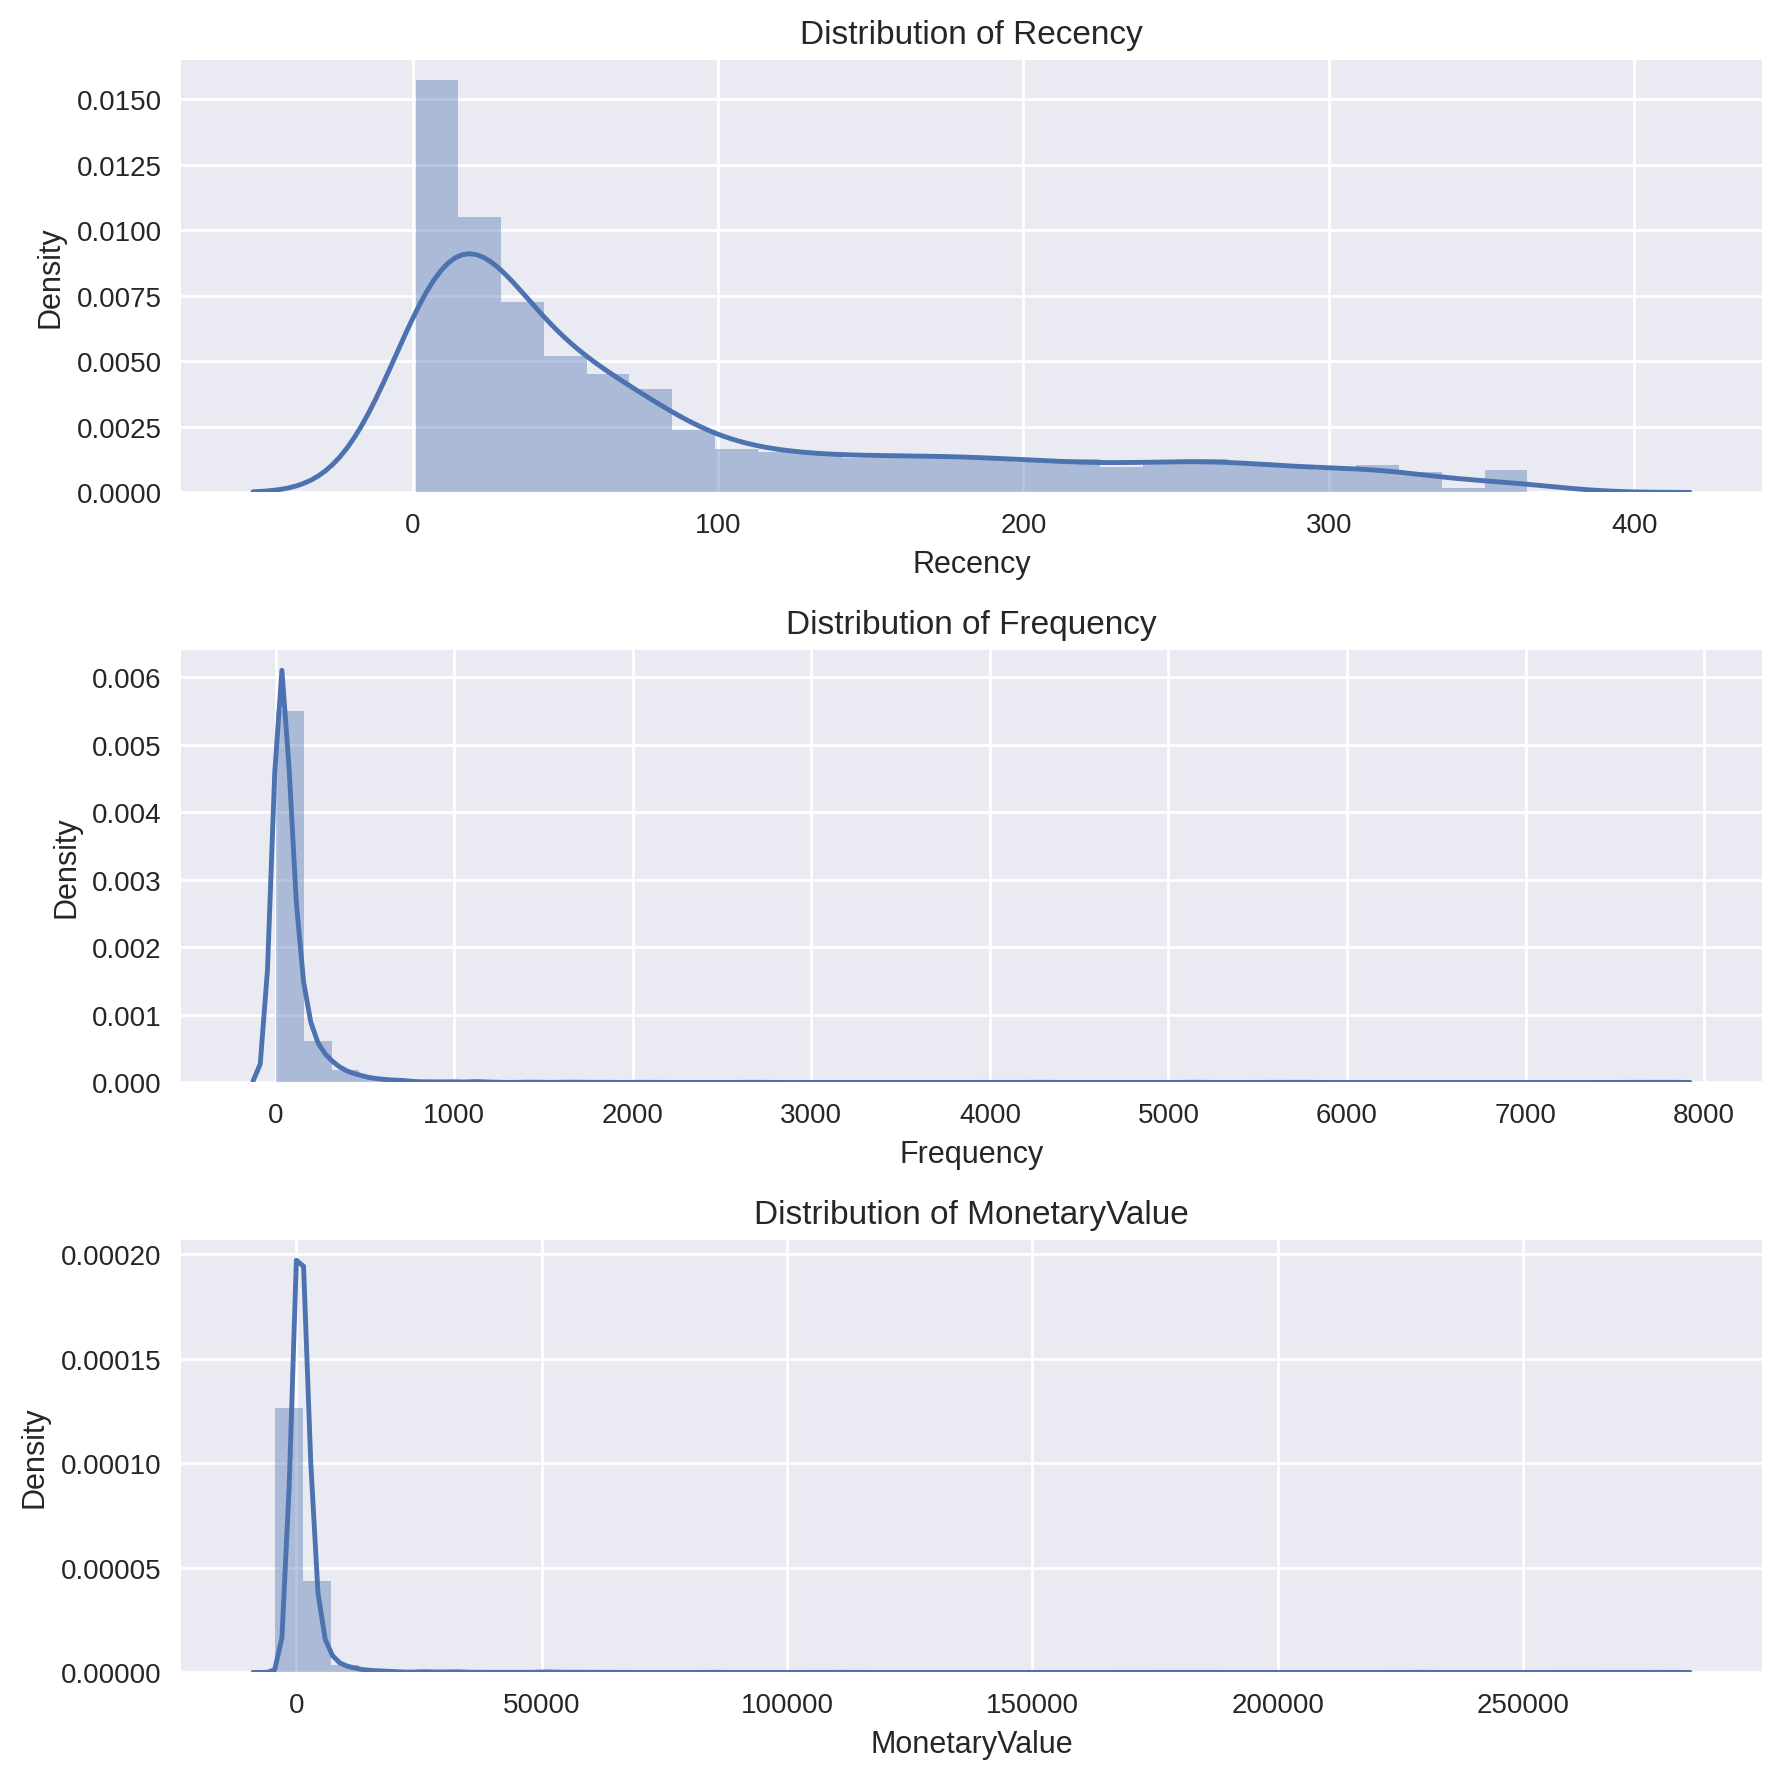

In [5]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm,'MonetaryValue')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

In [6]:
df_rfm.describe()

Recency    Frequency  MonetaryValue
count  4295.000000  4295.000000    4295.000000
mean     87.682654    91.265891    1861.569839
std      94.578749   227.634841    7996.244601
min       1.000000     1.000000   -4287.630000
25%      17.000000    17.000000     290.260000
50%      48.000000    41.000000     644.240000
75%     134.000000    99.000000    1585.915000
max     365.000000  7793.000000  279489.020000

In [7]:
# Copy original to new df
df_rfm_log = df_rfm.copy()

# Data Pre-Processing for Negative Value
df_rfm_log['MonetaryValue'] = (df_rfm_log['MonetaryValue'] - df_rfm_log['MonetaryValue'].min()) + 1

df_rfm_log.describe()

Recency    Frequency  MonetaryValue
count  4295.000000  4295.000000    4295.000000
mean     87.682654    91.265891    6150.199839
std      94.578749   227.634841    7996.244601
min       1.000000     1.000000       1.000000
25%      17.000000    17.000000    4578.890000
50%      48.000000    41.000000    4932.870000
75%     134.000000    99.000000    5874.545000
max     365.000000  7793.000000  283777.650000

Recency's: Skew: -0.4547480558293254, : SkewtestResult(statistic=-11.634943795553278, pvalue=2.737704076465579e-31)
Frequency's: Skew: -0.239827897754714, : SkewtestResult(statistic=-6.339202735355403, pvalue=2.309571642177164e-10)
MonetaryValue's: Skew: 0.1289857073105935, : SkewtestResult(statistic=3.44287521745169, pvalue=0.0005755648170534836)


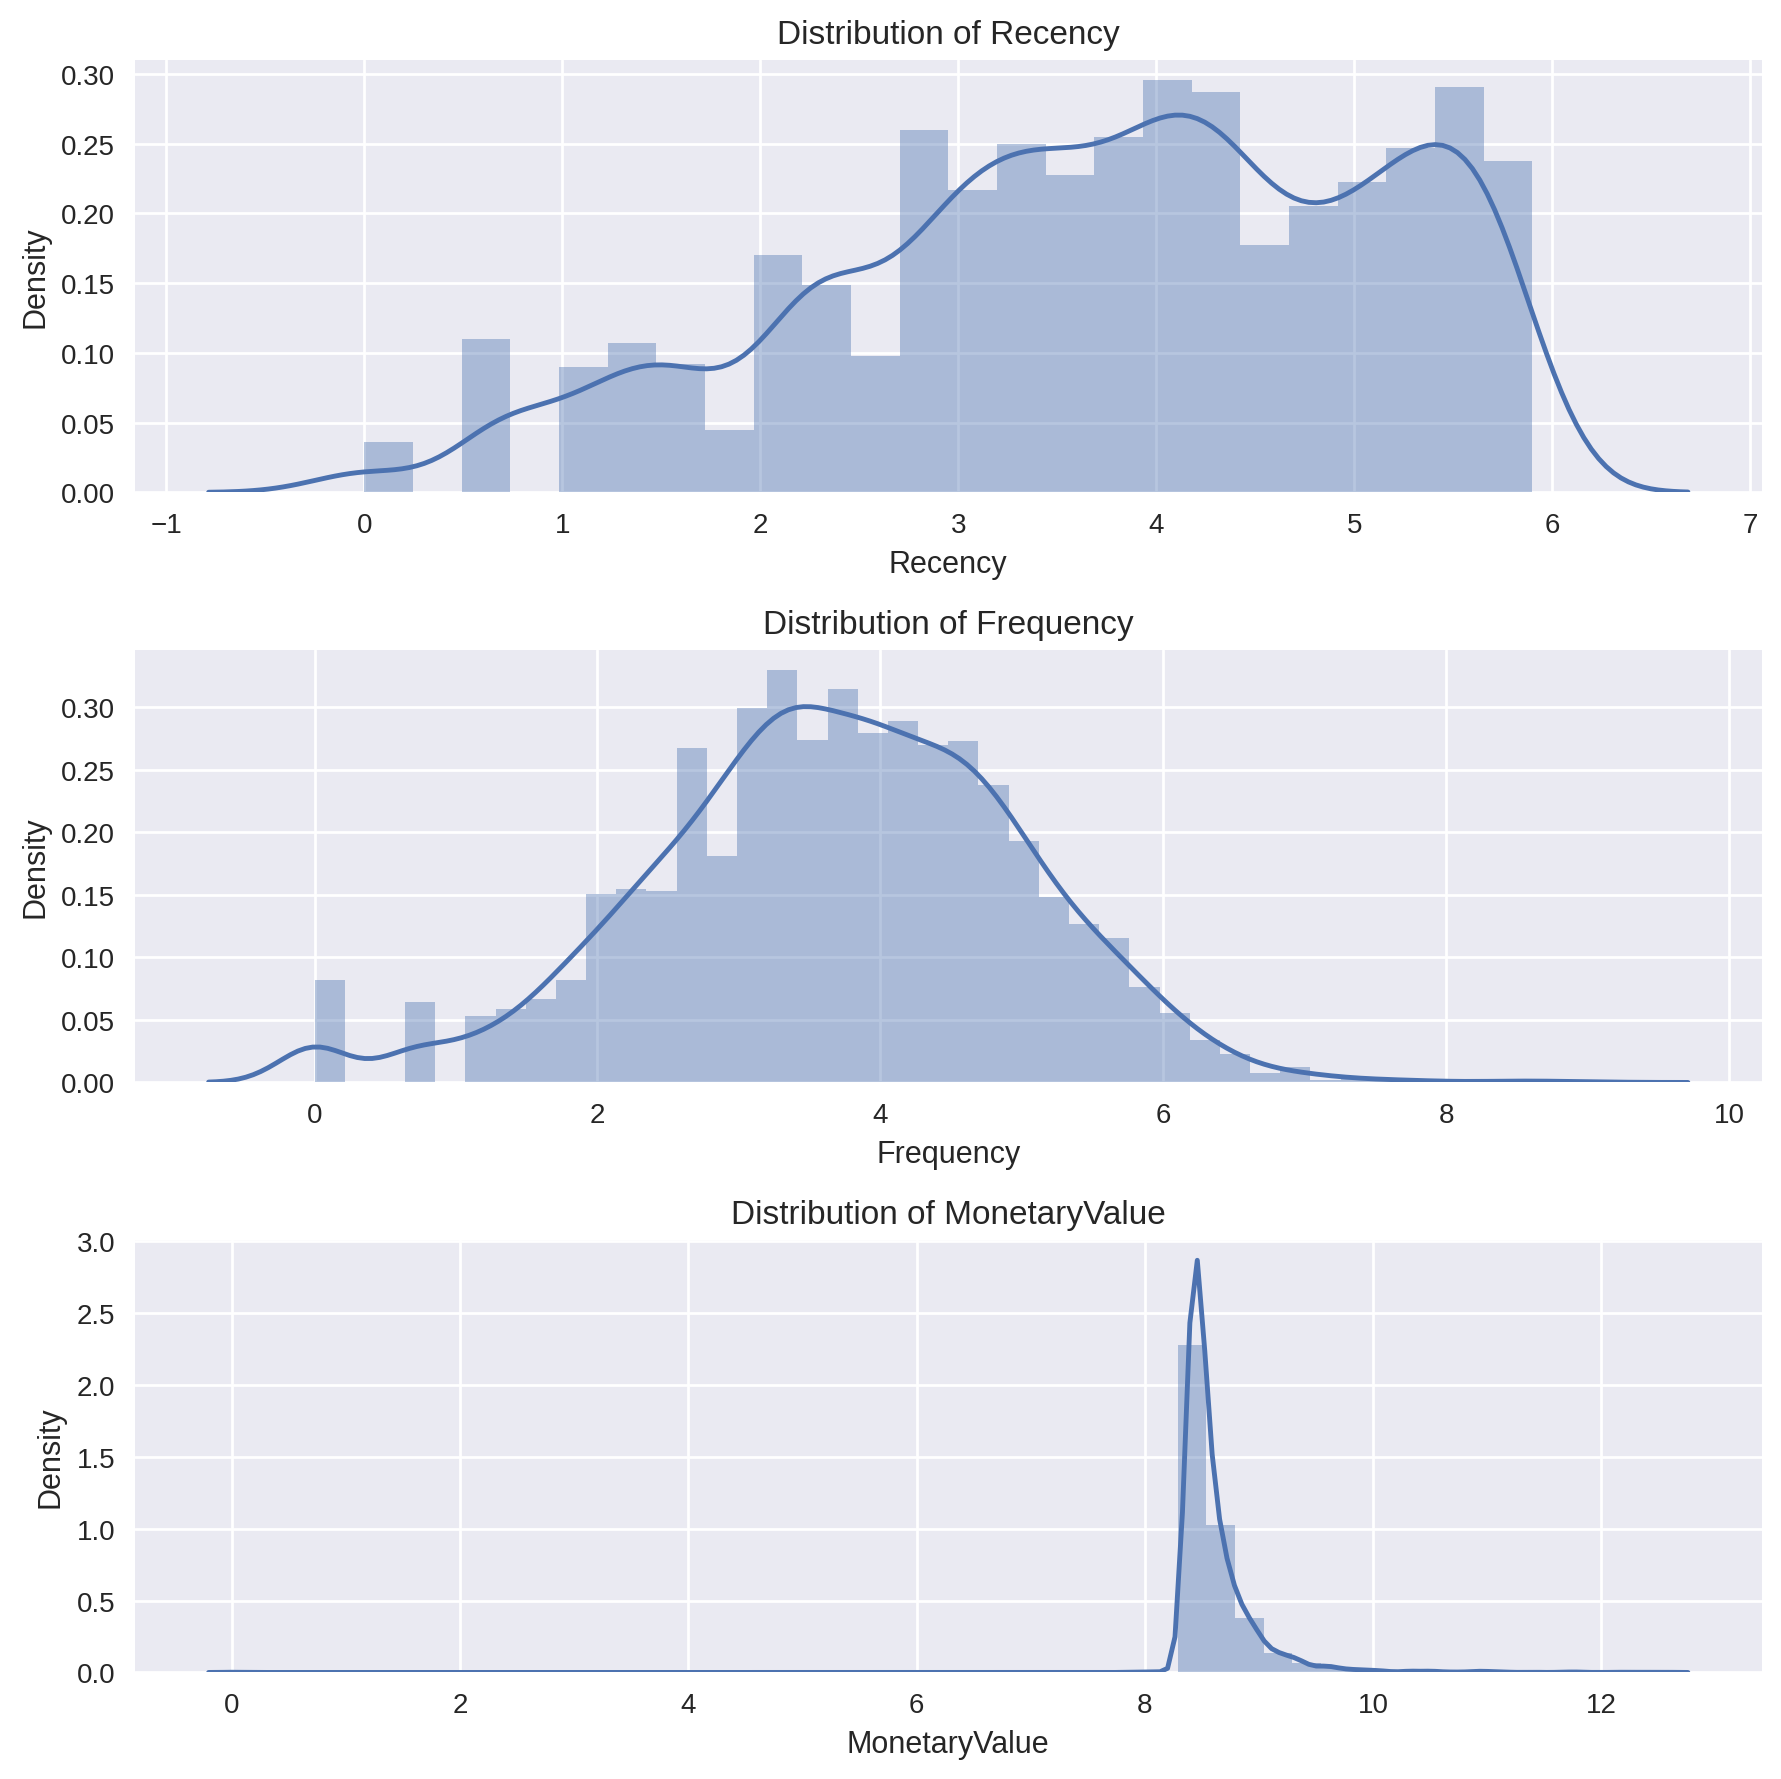

In [8]:
# Transform skewed data with log tranasformation
df_rfm_log = np.log(df_rfm_log)

# Check for skewness after log transformation
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'MonetaryValue')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

# Centering and Scaling

In [9]:
# Scaling data
scaler = StandardScaler()
scaler.fit(df_rfm_log)
df_rfm_normal = scaler.transform(df_rfm_log)

df_rfm_normal = pd.DataFrame(df_rfm_normal, index=df_rfm_log.index, columns=df_rfm_log.columns)

# Check result after standardising
df_rfm_normal.describe().round(3)

Recency  Frequency  MonetaryValue
count  4295.000   4295.000       4295.000
mean     -0.000     -0.000         -0.000
std       1.000      1.000          1.000
min      -2.672     -2.765        -23.890
25%      -0.643     -0.633         -0.511
50%       0.101      0.029         -0.304
75%       0.836      0.692          0.180
max       1.554      3.977         10.935

# K-Means Clustering

In [10]:
def optimal_kmeans(dataset, start=2, end=11):
    '''
    Calculate the optimal number of kmeans
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values of Inertia 
       
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
   
    inertia = []

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        # Calcualte model performance
       
        inertia_score = round(kmeans.inertia_, 2)

        # Append score to lists
       
        n_clu.append(n_clusters)
        inertia.append(inertia_score)

        print("No. Clusters: {},  Inertia: {}, Inertia Delta: {}".format(
            n_clusters, inertia_score, (inertia[n_clusters - start] - inertia[n_clusters - start - 1])))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(9,6))

            plt.title('Within-Cluster Sum-of-Squares / Inertia')
            sns.pointplot(x=n_clu, y=inertia)
            plt.show()

No. Clusters: 2,  Inertia: 7710.68, Inertia Delta: 0.0
No. Clusters: 3,  Inertia: 5971.49, Inertia Delta: -1739.1900000000005
No. Clusters: 4,  Inertia: 5002.54, Inertia Delta: -968.9499999999998
No. Clusters: 5,  Inertia: 4203.47, Inertia Delta: -799.0699999999997
No. Clusters: 6,  Inertia: 3656.09, Inertia Delta: -547.3800000000001
No. Clusters: 7,  Inertia: 3124.79, Inertia Delta: -531.3000000000002
No. Clusters: 8,  Inertia: 2704.94, Inertia Delta: -419.8499999999999
No. Clusters: 9,  Inertia: 2452.92, Inertia Delta: -252.01999999999998
No. Clusters: 10,  Inertia: 2233.77, Inertia Delta: -219.1500000000001


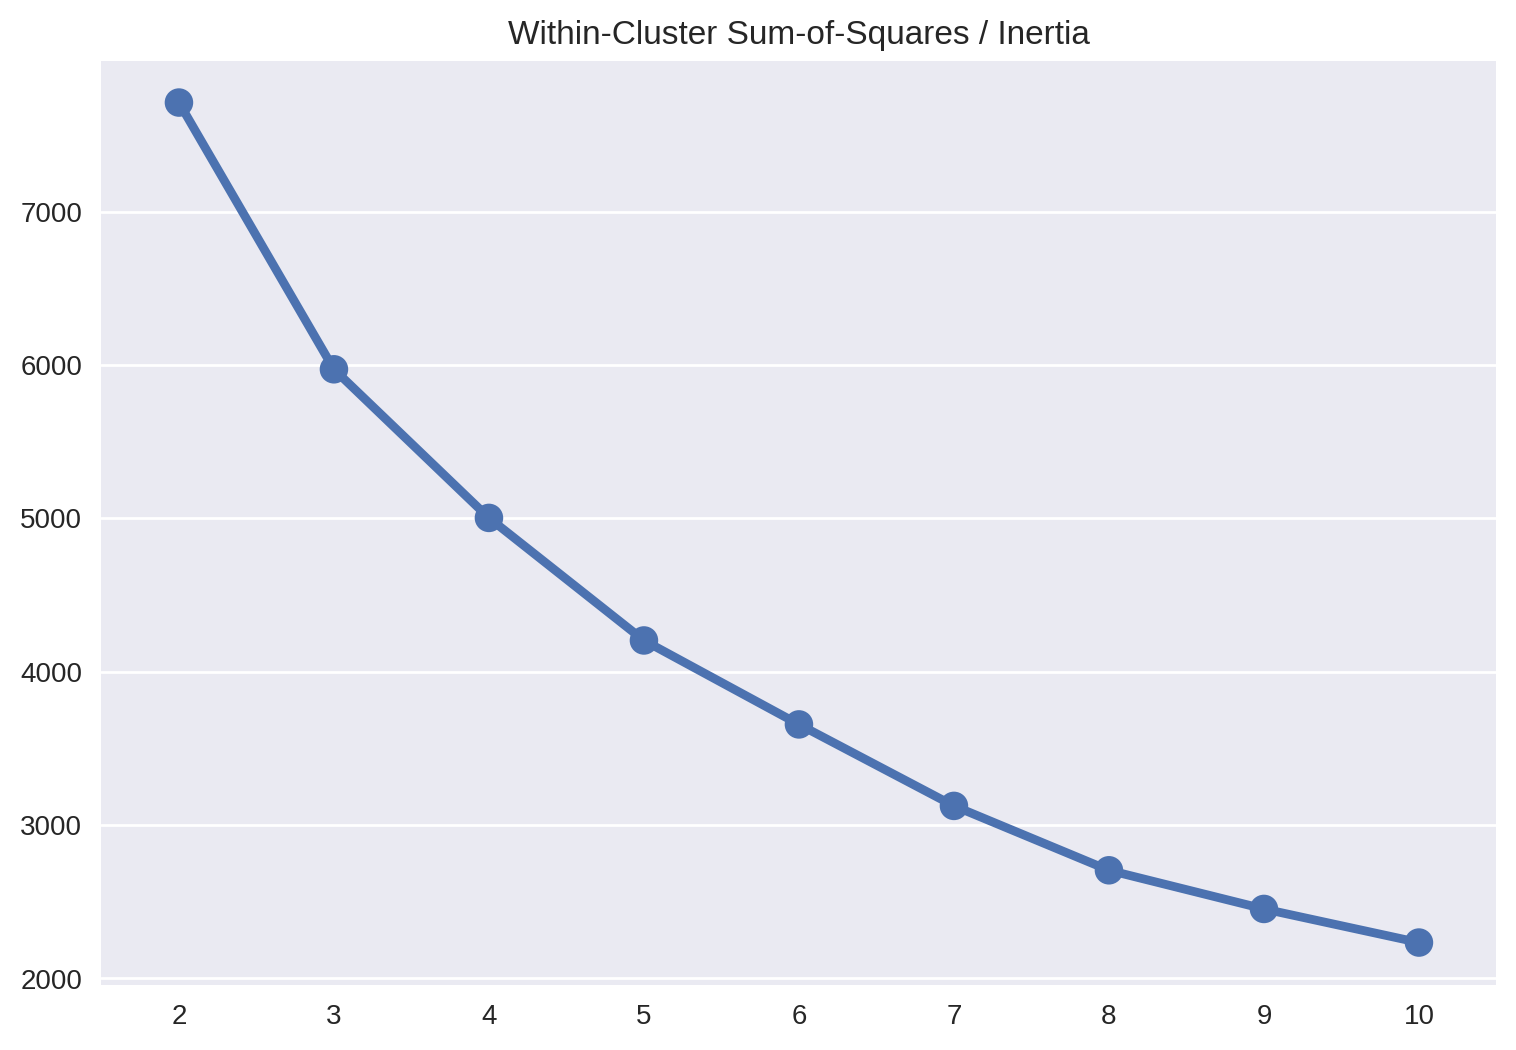

In [11]:
optimal_kmeans(df_rfm_normal)

Based on the inertia and silhouette score, the optimal number of cluster is 4. However, during the implemention of KMEans, cluster of 3, 4, and 5 will be tested to experiment which cluster makes most business sense.

In [12]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        normalised_df_rfm : dataframe. Normalised rfm dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        original_df_rfm : dataframe. Original rfm dataset to assign the labels to.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

# Plotting Silhouette Plots

In [13]:
def plot_silhouette_score(df, labels):
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    
    silhouette_vals = silhouette_samples(df, labels)

    y_ax_lower, y_ax_upper = 0, 0
    y_tick = []

    for i, c in enumerate(cluster_labels):
    
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
    
        print('Cluster', c, 'avg silhouette:', np.mean(c_silhouette_vals))
    
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        y_tick.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    print('Total avg silhouette:', silhouette_avg)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.yticks=(y_tick, cluster_labels + 1)
    plt.ylabel('Points')
    plt.xlabel('Silhouette')
    plt.tight_layout()

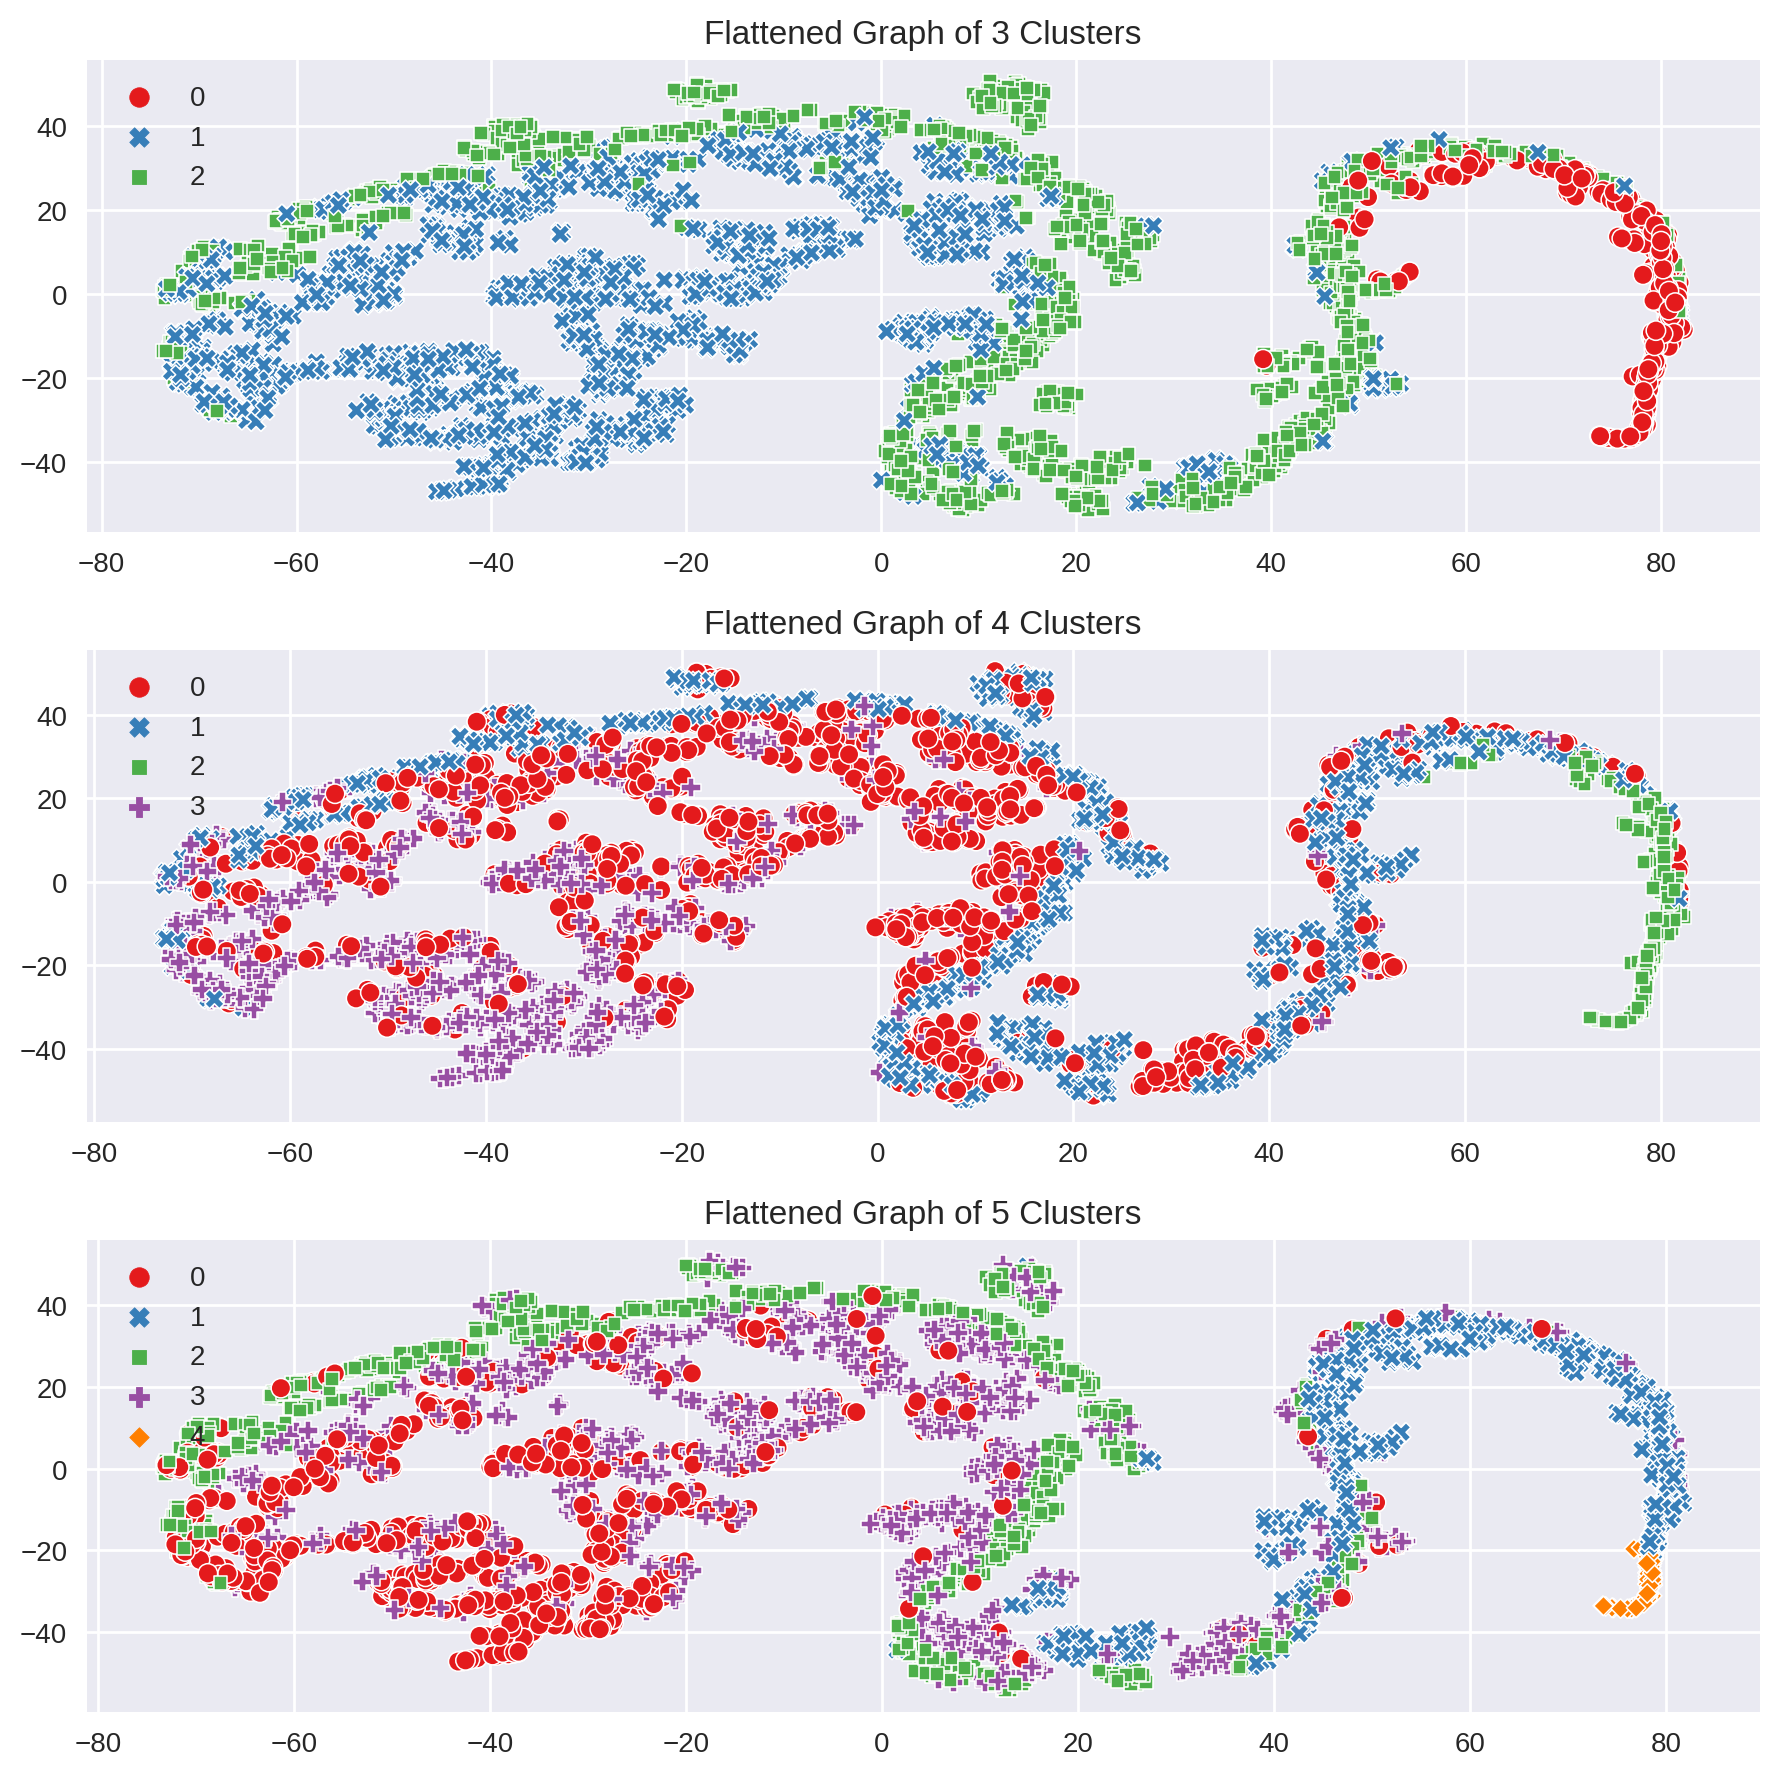

In [14]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(df_rfm_normal, 3, df_rfm)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(df_rfm_normal, 4, df_rfm)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(df_rfm_normal, 5, df_rfm)

plt.tight_layout()
plt.savefig('flattened.png', format='png', dpi=1000)

### Silhouette plot for 3 cluster solution

Cluster 0 avg silhouette: 0.23038982157637347
Cluster 1 avg silhouette: 0.4064928906660983
Cluster 2 avg silhouette: 0.31895656489036955
Total avg silhouette: 0.35290092207973167


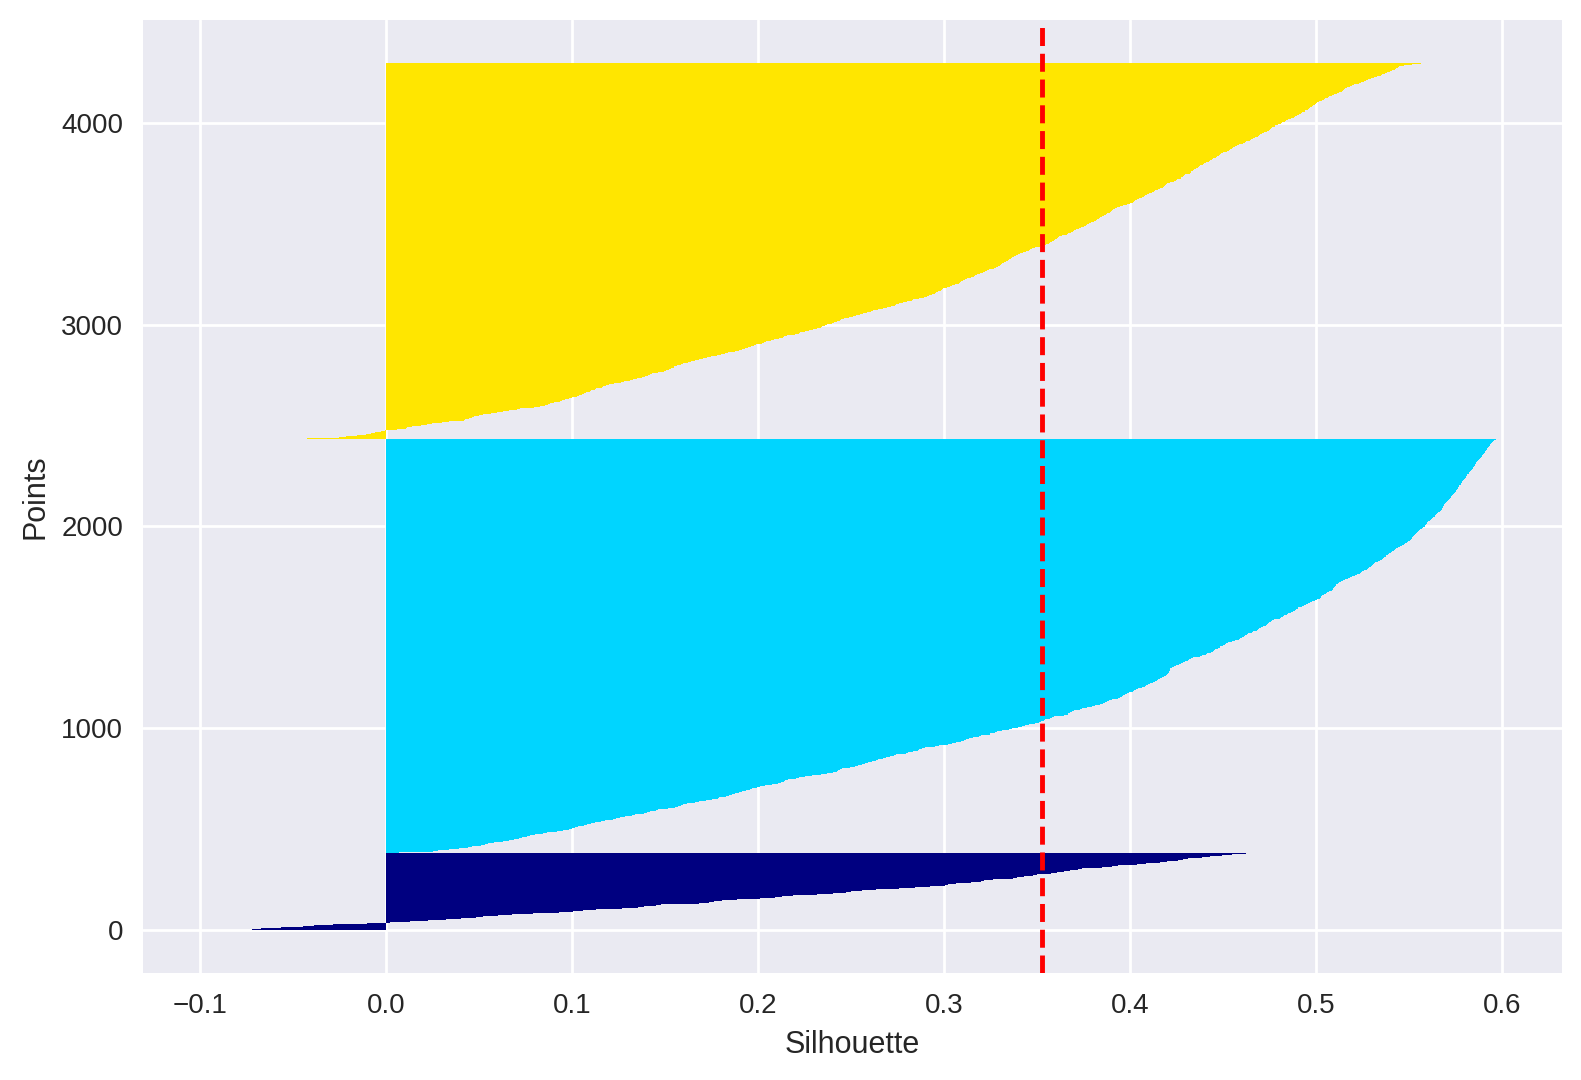

In [15]:
plot_silhouette_score(df_rfm_normal, df_rfm_k3['Cluster'])

### Silhouette plot for 4 cluster solution

Cluster 0 avg silhouette: 0.33330158291326517
Cluster 1 avg silhouette: 0.2582628295677294
Cluster 2 avg silhouette: 0.21331156440680116
Cluster 3 avg silhouette: 0.282577327747549
Total avg silhouette: 0.2878744760894411


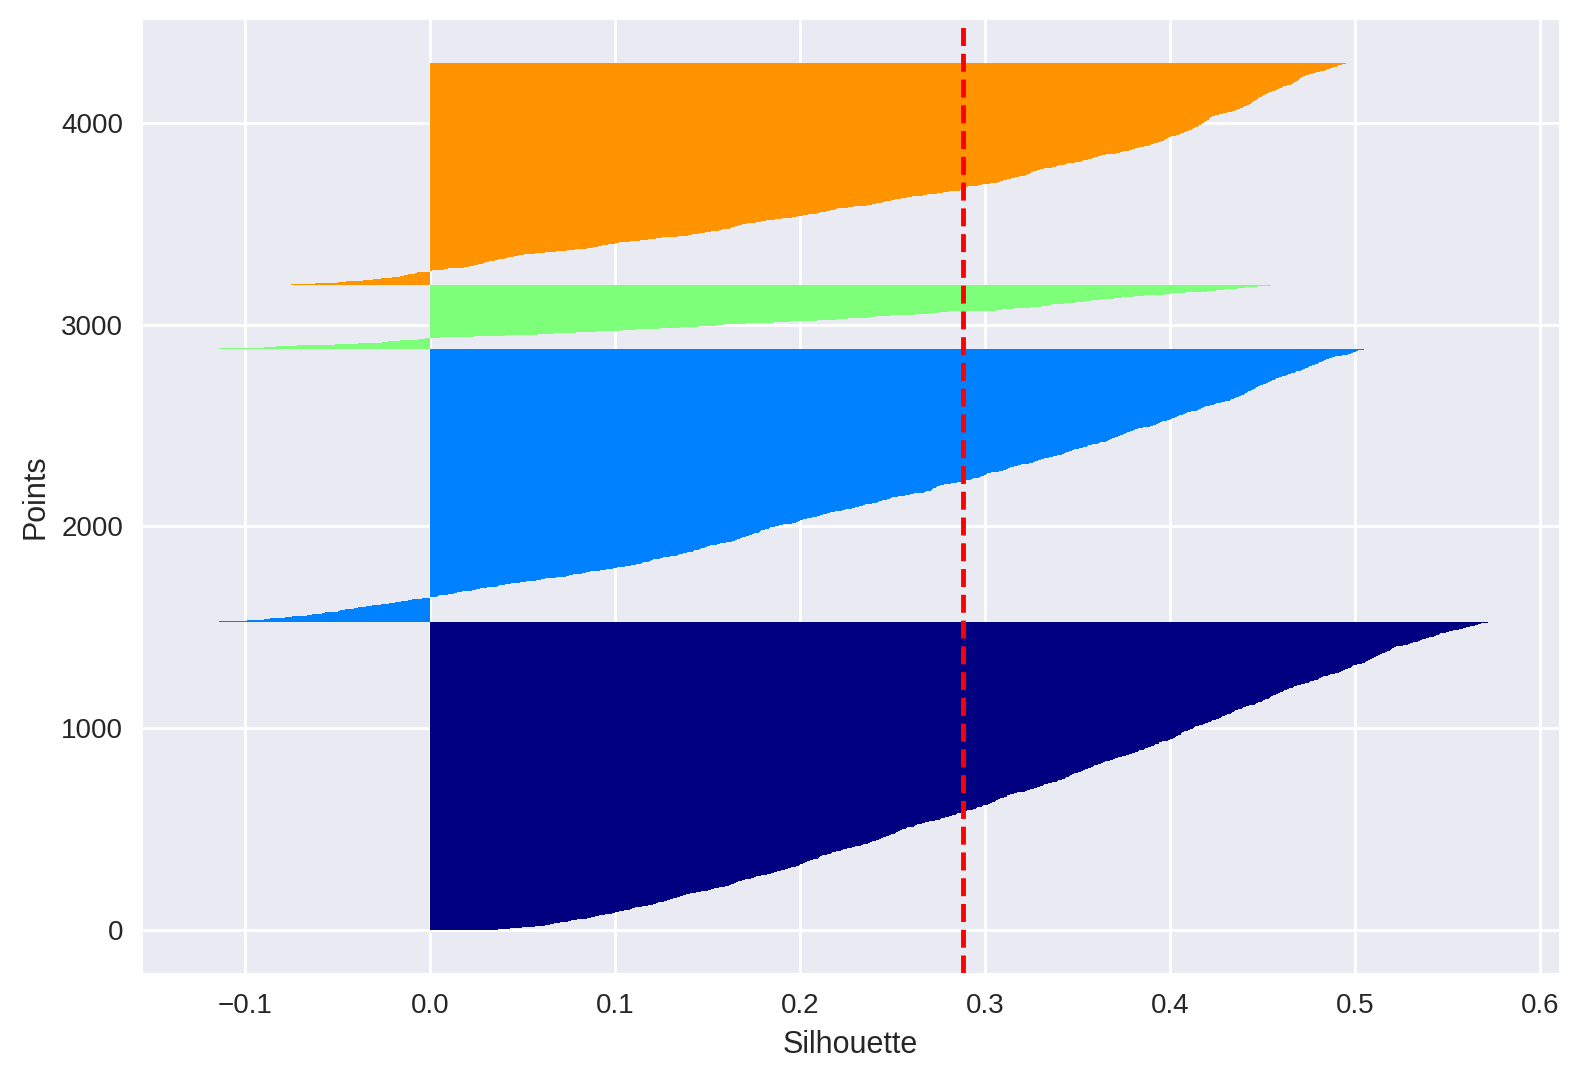

In [16]:
plot_silhouette_score(df_rfm_normal, df_rfm_k4['Cluster'])

### Silhouette plot for 5 cluster solution

Cluster 0 avg silhouette: 0.3013700171326968
Cluster 1 avg silhouette: 0.24125012004129084
Cluster 2 avg silhouette: 0.2790169666963563
Cluster 3 avg silhouette: 0.33877708264567075
Cluster 4 avg silhouette: 0.2895968955355058
Total avg silhouette: 0.29671389243672125


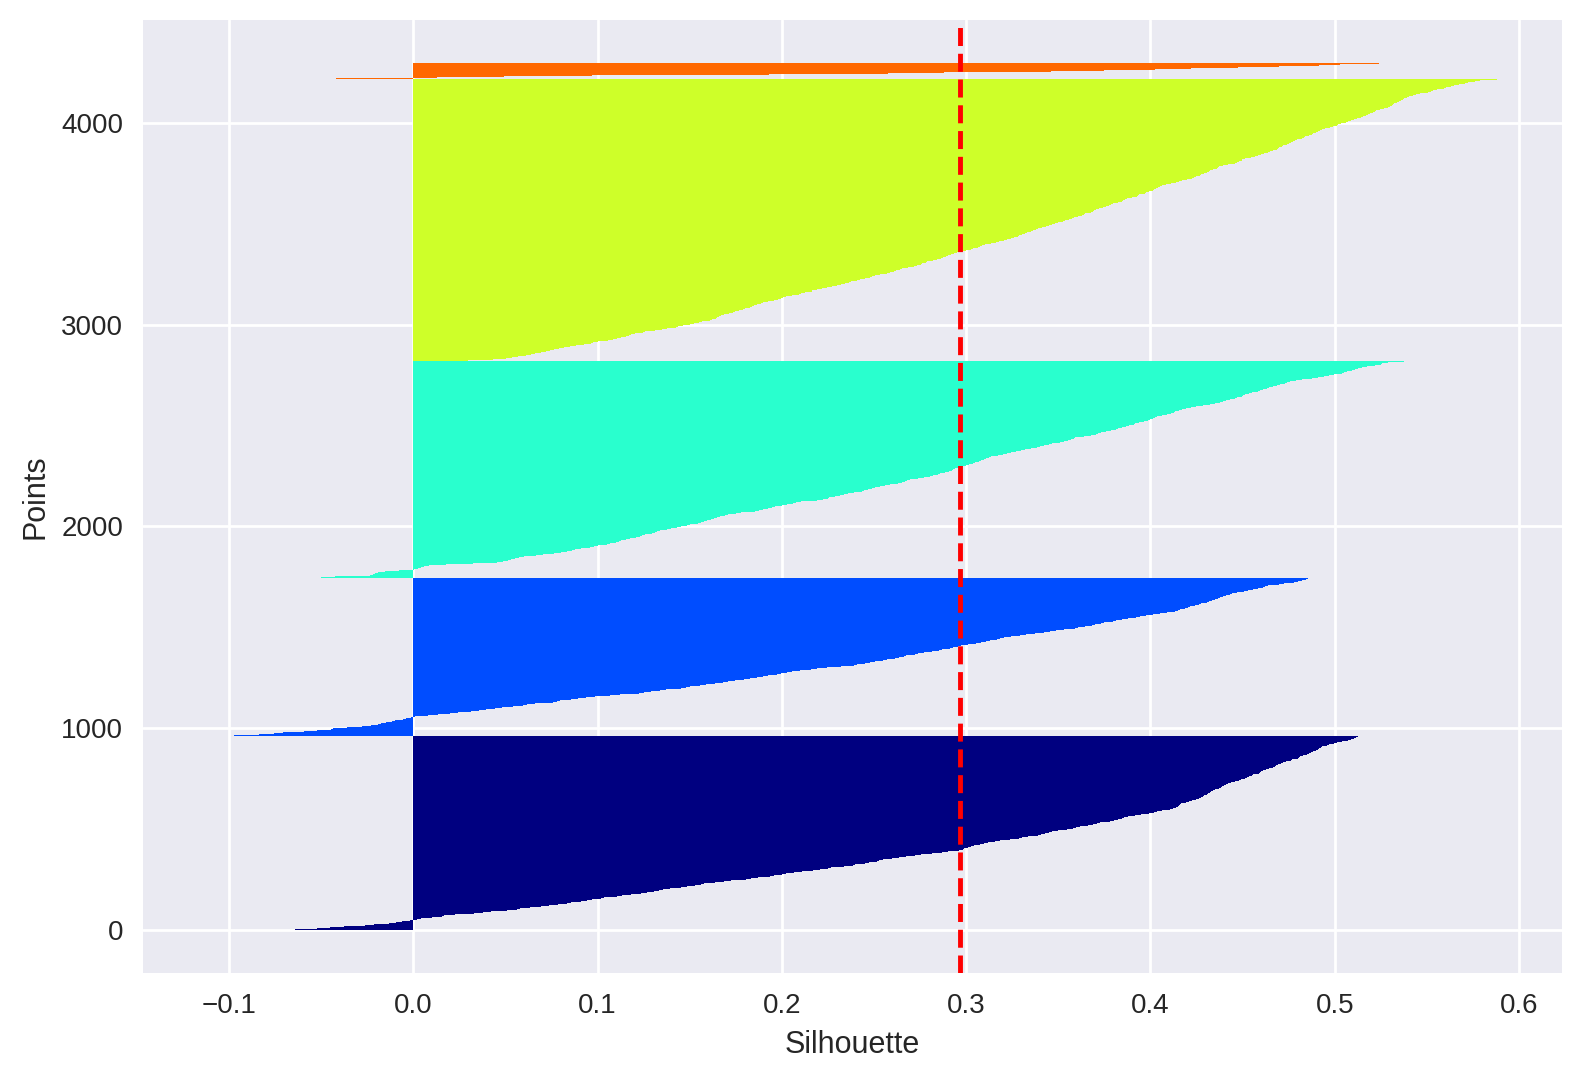

In [17]:
plot_silhouette_score(df_rfm_normal, df_rfm_k5['Cluster'])

# Building Customer Personas

## Summary Statistics

In [18]:
def rfm_values(df):
    '''
    Calcualte average RFM values and size for each cluster

    '''
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': ['mean', 'count']
    }).round(0)
    
    return df_new

In [19]:
rfm_values(df_rfm_k3)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          14.0     422.0       11853.0   383
1         153.0      23.0         438.0  2053
2          31.0      99.0        1375.0  1859

In [20]:
rfm_values(df_rfm_k4)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         115.0      57.0         887.0  1529
1          16.0     112.0        1492.0  1351
2          14.0     452.0       13603.0   317
3         160.0       9.0         283.0  1098

In [21]:
rfm_values(df_rfm_k5)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         166.0       9.0         260.0   961
1          20.0     240.0        3639.0   786
2          18.0      55.0         804.0  1073
3         130.0      54.0         834.0  1395
4          10.0     768.0       35741.0    80

# Snake Plots

In [22]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    '''
    Transform dataframe and plot snakeplot
    '''
    # Transform df_normal as df and add cluster column
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm.index,
                                       columns=df_rfm.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    


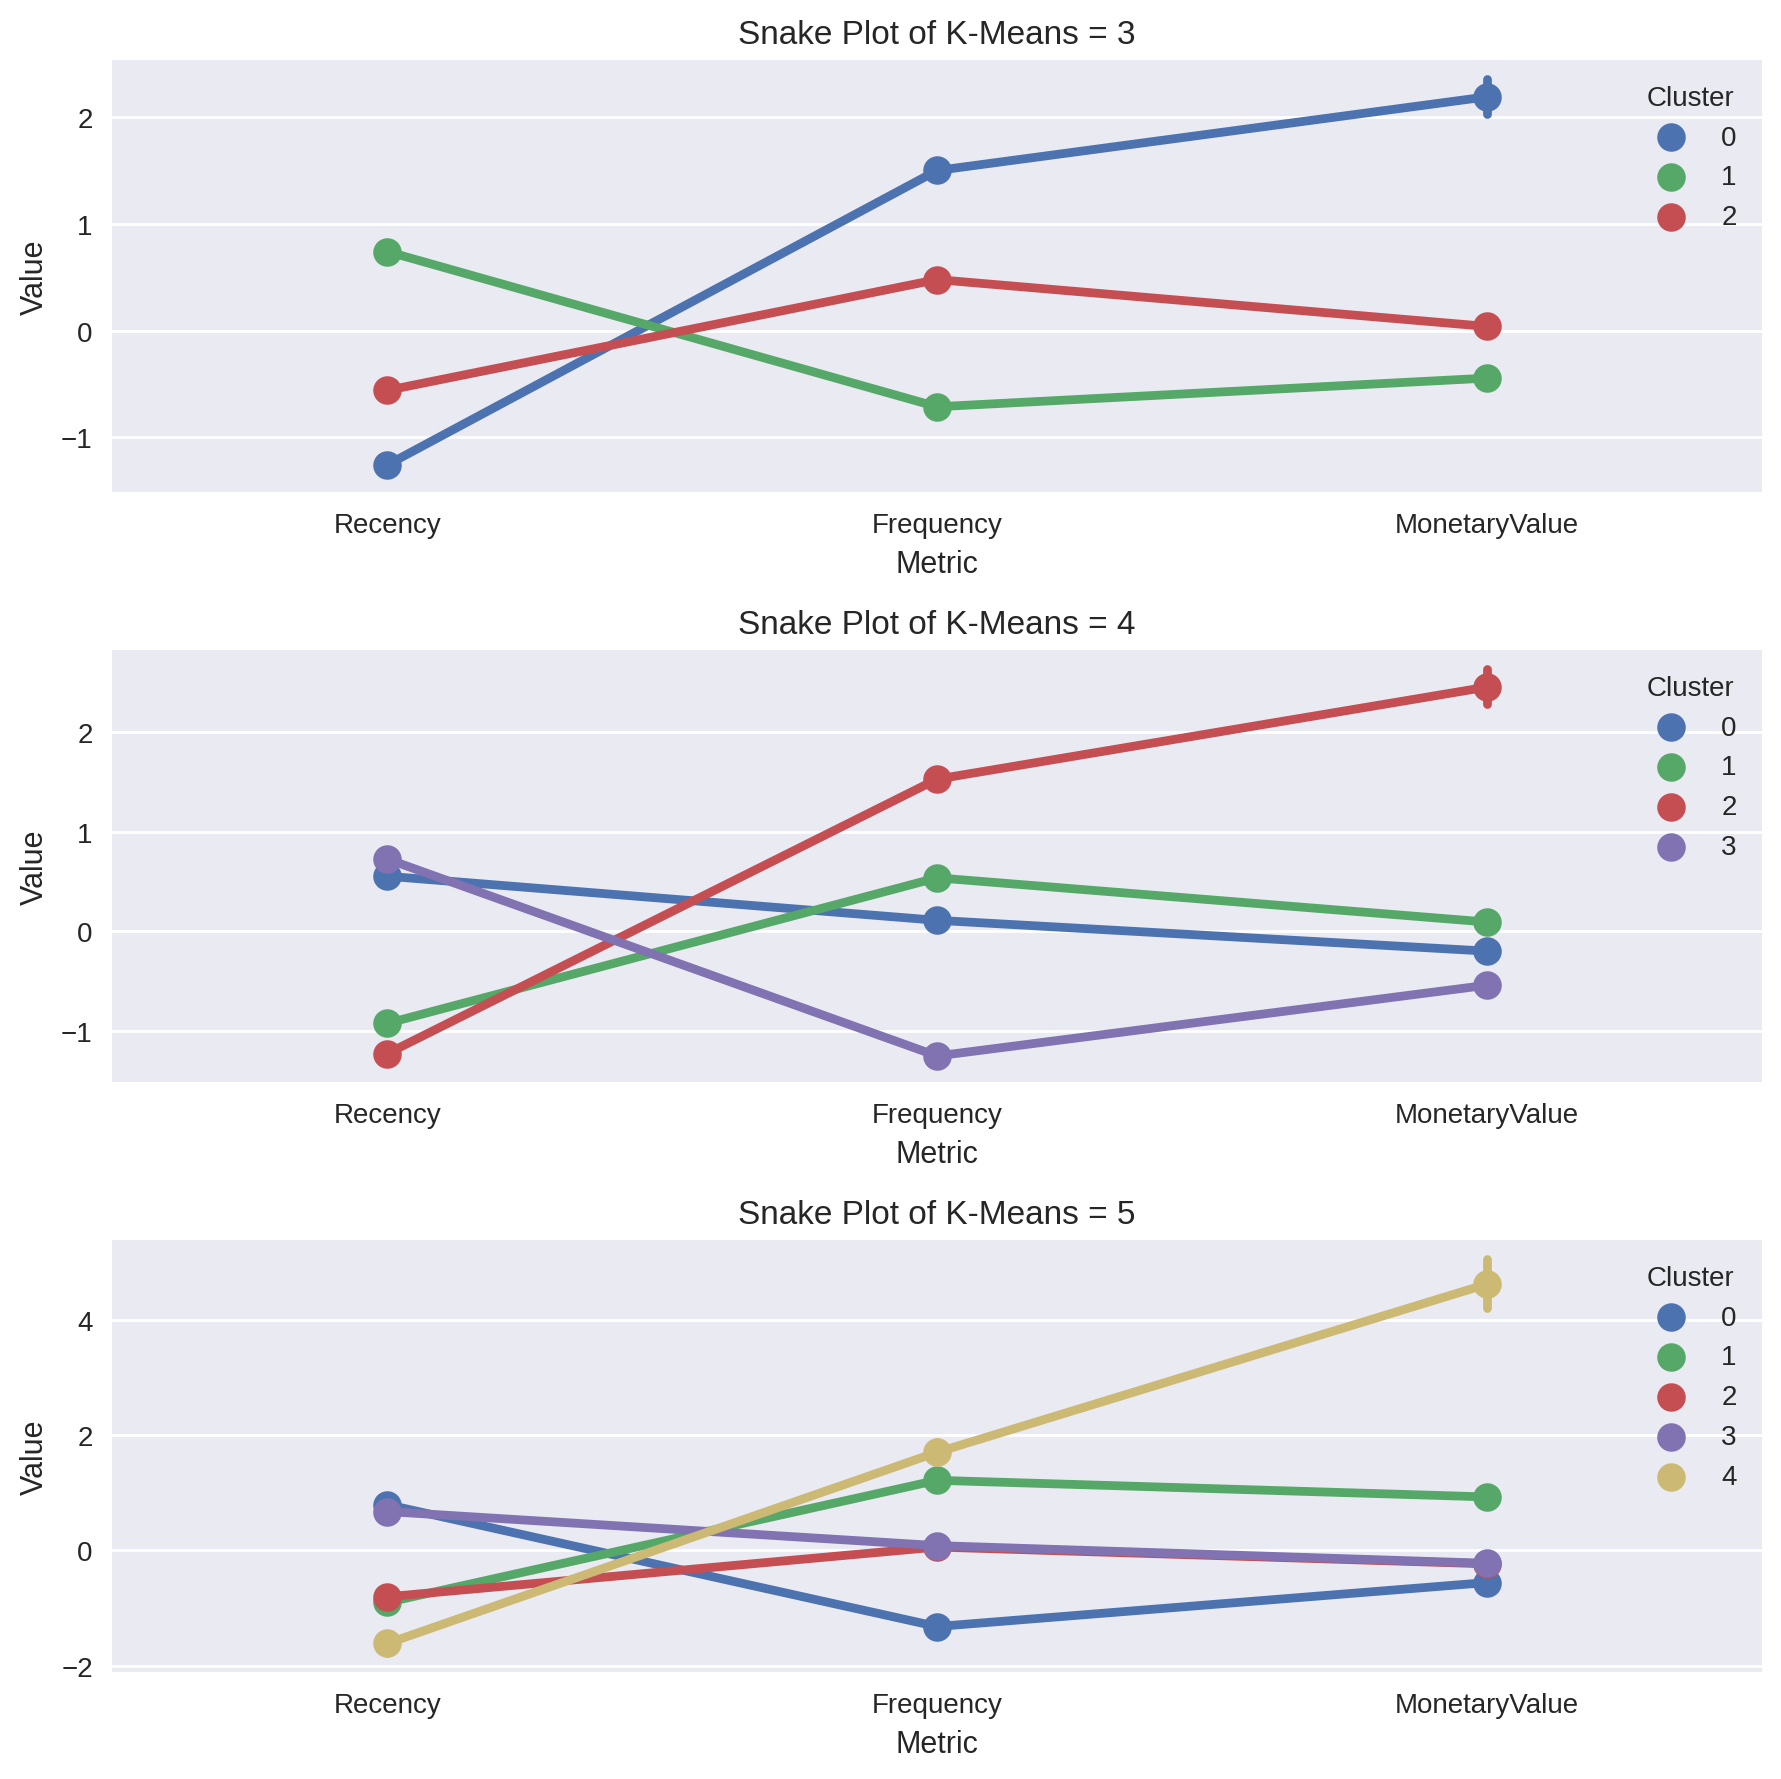

In [23]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(df_rfm_normal, df_rfm_k3, df_rfm)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(df_rfm_normal, df_rfm_k4, df_rfm)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(df_rfm_normal, df_rfm_k5, df_rfm)

plt.tight_layout()

# Relative Importance of Segment Attributes

In [24]:
def relative_importance(df_rfm_kmeans, df_rfm_original):
    '''
    Calculate relative importance of segment attributes and plot heatmap
    '''
    # Calculate average RFM values for each cluster
    cluster_avg = df_rfm_kmeans.groupby(['Cluster']).mean() 

    # Calculate average RFM values for the total customer population
    population_avg = df_rfm.mean()

    # Calculate relative importance of cluster's attribute value compared to population
    relative_imp = cluster_avg / population_avg - 1

    sns.heatmap(data=relative_imp, annot=True, fmt='.2f')
    

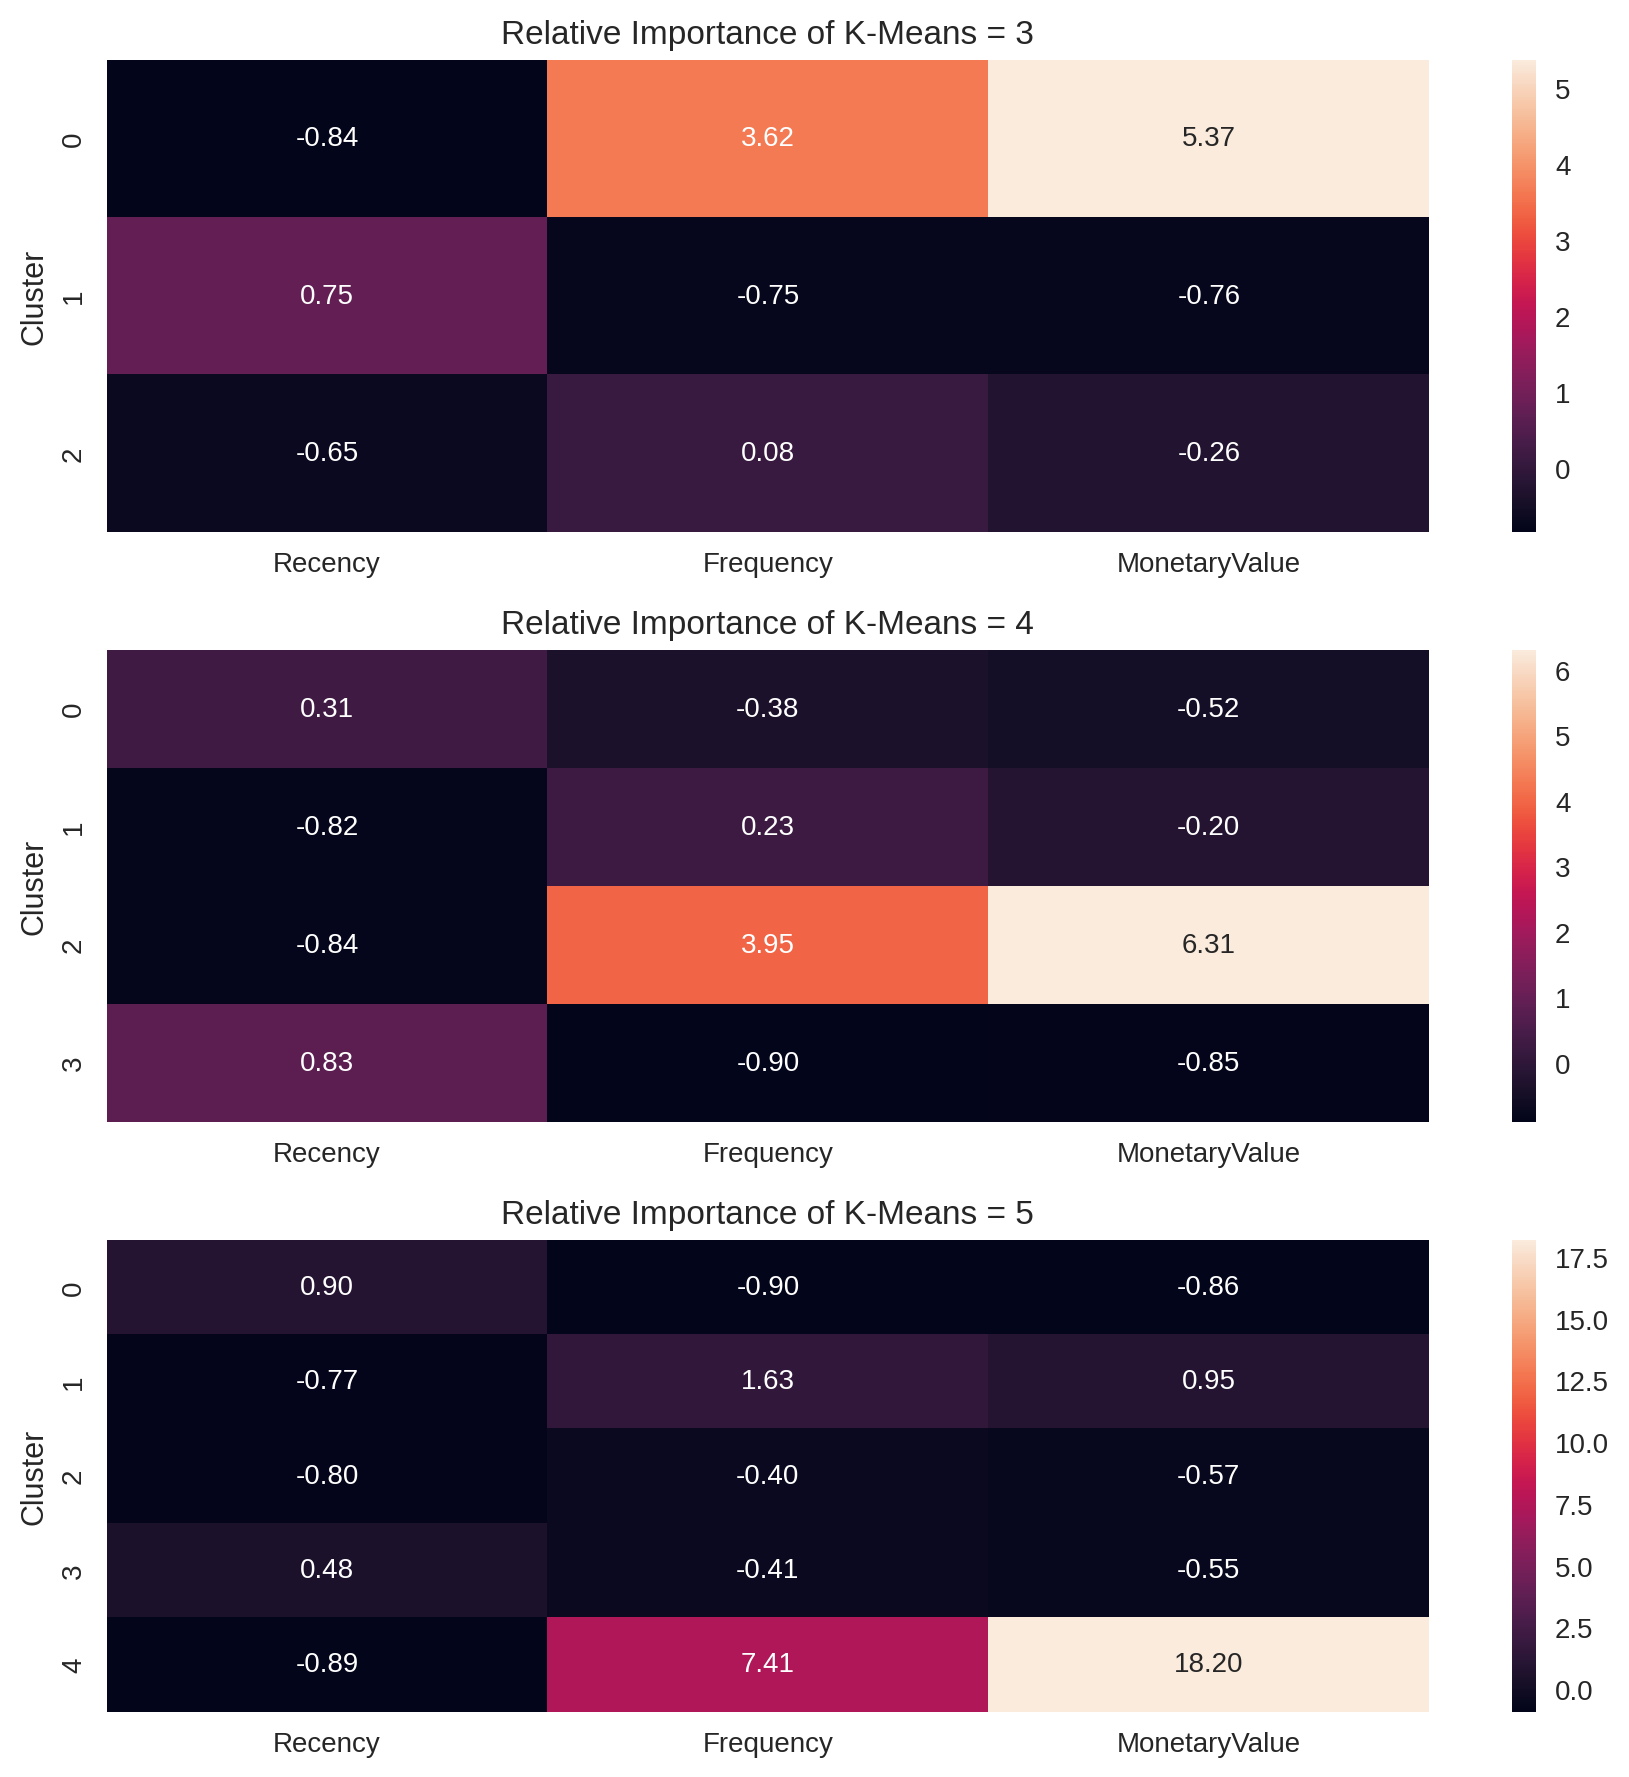

In [25]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Relative Importance of K-Means = 3')
relative_importance(df_rfm_k3, df_rfm)

plt.subplot(3, 1, 2)
plt.title('Relative Importance of K-Means = 4')
relative_importance(df_rfm_k4, df_rfm)

plt.subplot(3, 1, 3)
plt.title('Relative Importance of K-Means = 5')
relative_importance(df_rfm_k5, df_rfm)

plt.tight_layout()

# Ward's Minimum Variance

* The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize Ward's criterion.

* Ward minimizes the euclidean distance of the clusters being merged (is the hierarchical analogue of K-means, so it can be used to initialize it)
* strength: less susceptible to noise and outliers
* limitations: biased towards globular clusters

In [26]:
def plot_dendrogram(model, **kwargs):
    # create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [27]:
ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')  # setting distance_threshold=0 ensures we compute the full tree
clusters_customers = ward.fit_predict(df_rfm_normal)

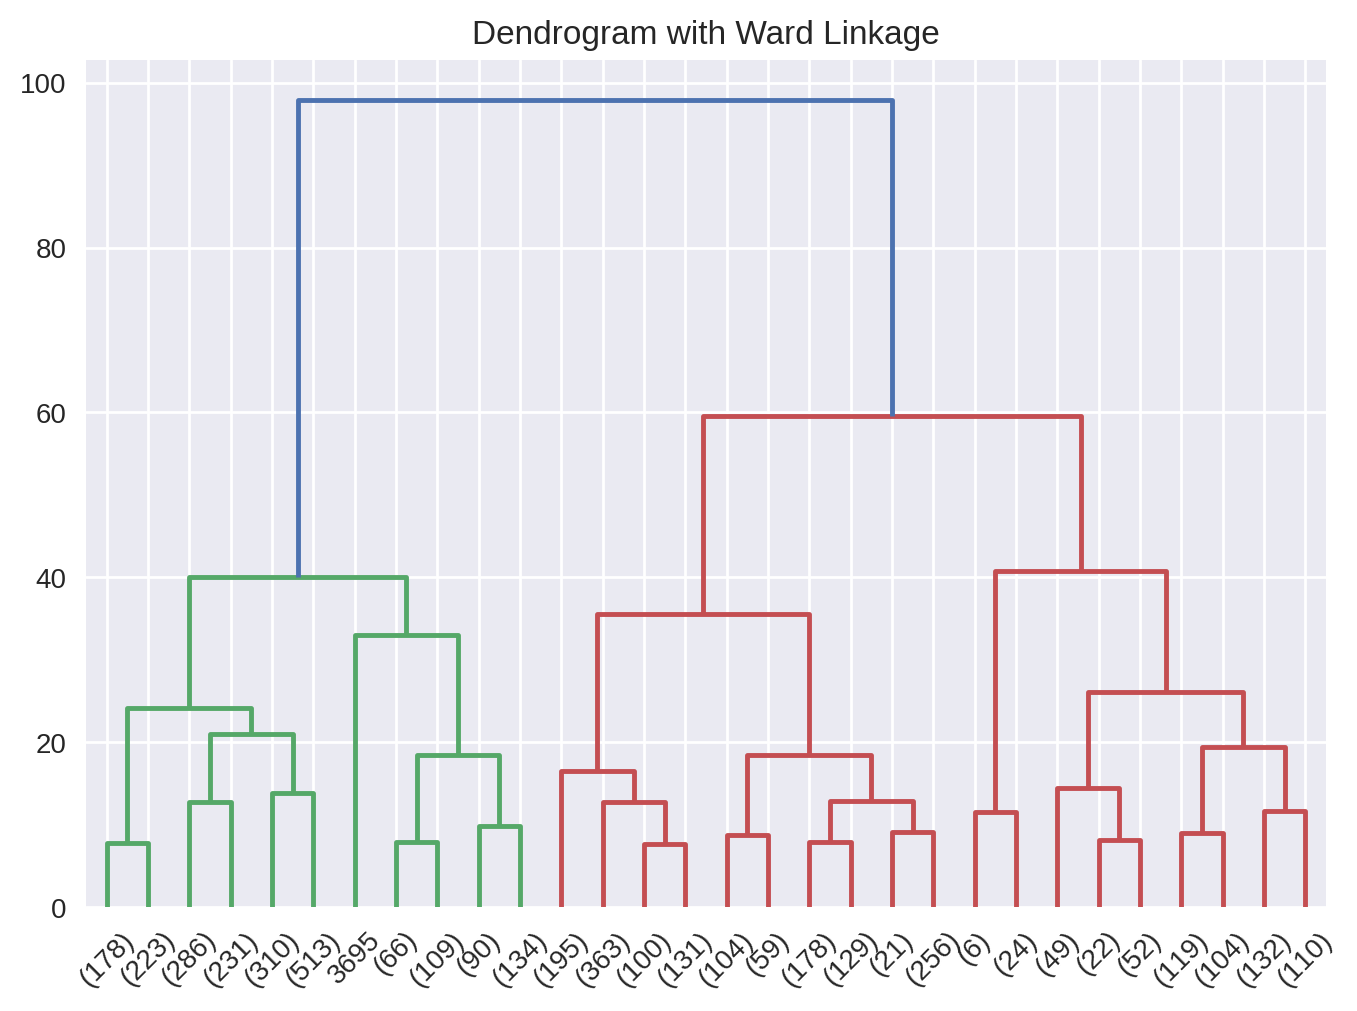

In [28]:
plt.title('Dendrogram with Ward Linkage')
plot_dendrogram(ward, truncate_mode='lastp')  # plot the last p non-singleton clusters formed in the linkage

Cut the dendogram in order to have two clusters

In [29]:
def wards(normalised_df_rfm, clusters_number, original_df_rfm):
    '''
    Implement wards clustering on dataset
    
    INPUT:
        normalised_df_rfm : dataframe. Normalised rfm dataset for wards linkage to fit.
        clusters_number : int. Number of clusters to form.
        original_df_rfm : dataframe. Original rfm dataset to assign the labels to.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''
    
    ward = AgglomerativeClustering(distance_threshold=None, n_clusters=clusters_number, linkage='ward')
    ward.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = ward.fit_predict(normalised_df_rfm)
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

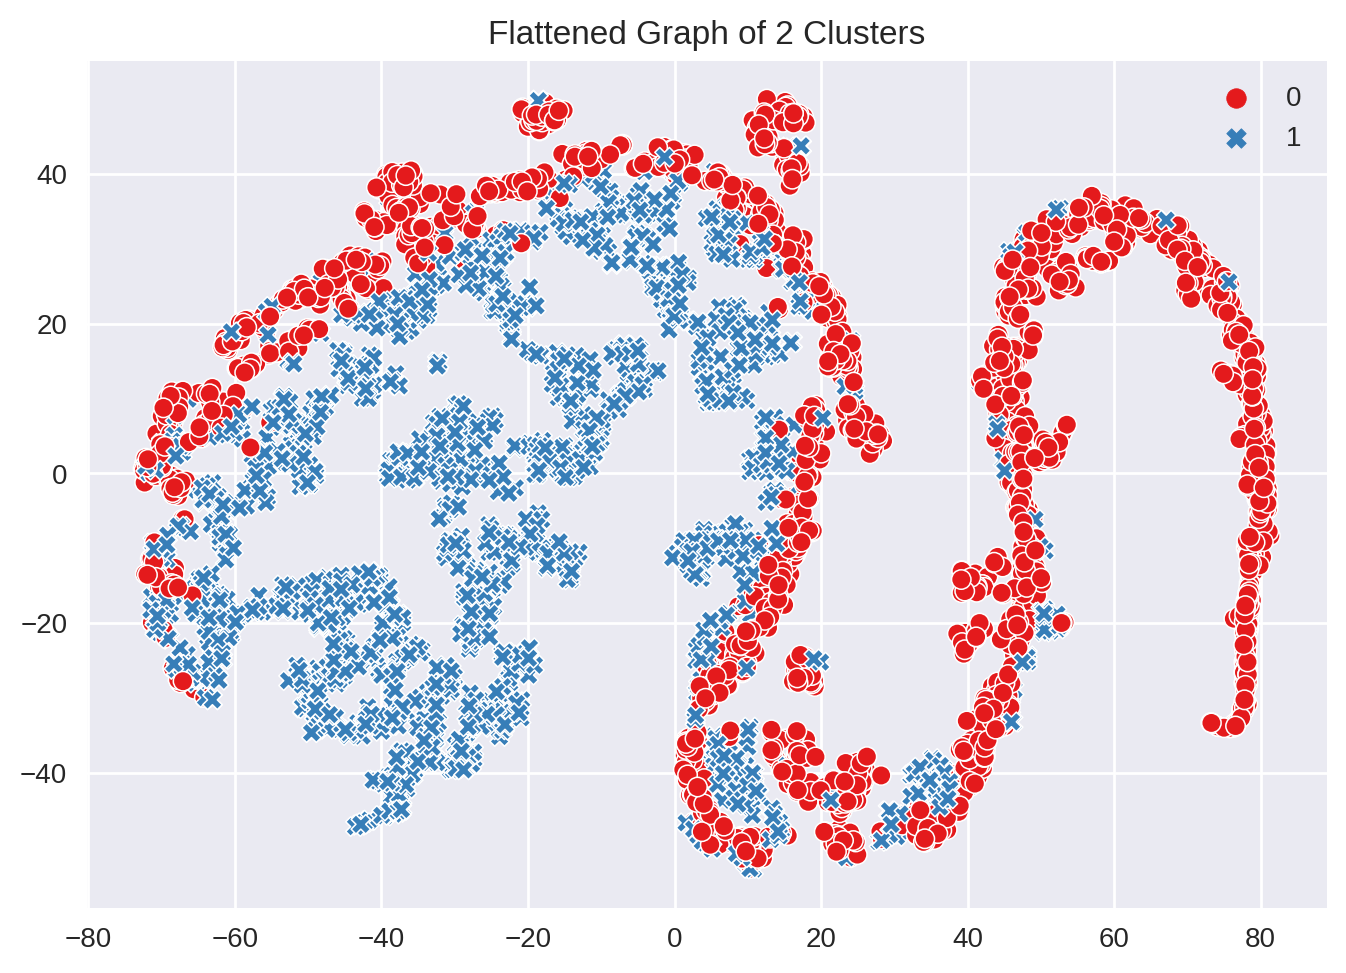

In [30]:
df_rfm_W=wards(df_rfm_normal,2,df_rfm)

In [31]:
df_rfm_W.head()

Recency  Frequency  MonetaryValue  Cluster
CustomerID                                            
12346.0         326          2           0.00        1
12347.0           3        151        3598.21        0
12348.0          76         31        1797.24        1
12349.0          19         73        1757.55        0
12350.0         311         17         334.40        1

# Silhouette Plot for 2 cluster solution

Cluster 0 avg silhouette: 0.22582008939567866
Cluster 1 avg silhouette: 0.48196276863789483
Total avg silhouette: 0.35350378584680436


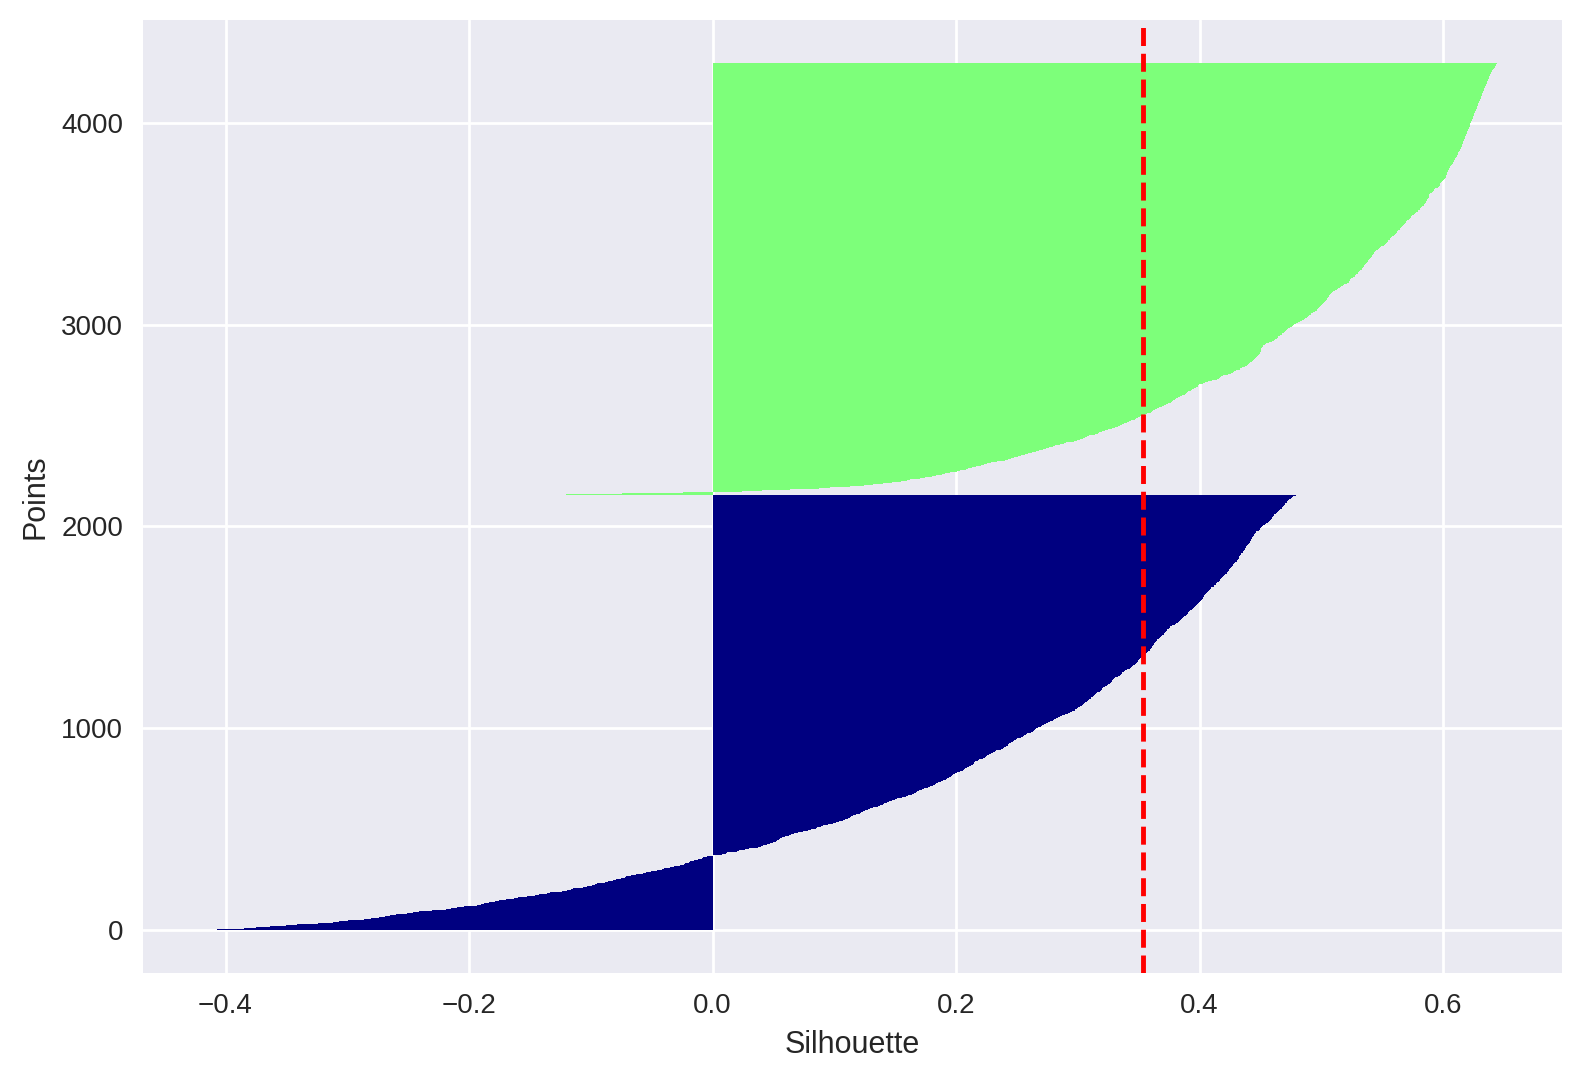

In [32]:
plot_silhouette_score(df_rfm_normal, df_rfm_W['Cluster'])

# Building Customer Personas

## Summary Statistics

In [33]:
rfm_values(df_rfm_W)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          25.0     155.0        3226.0  2154
1         151.0      28.0         489.0  2141

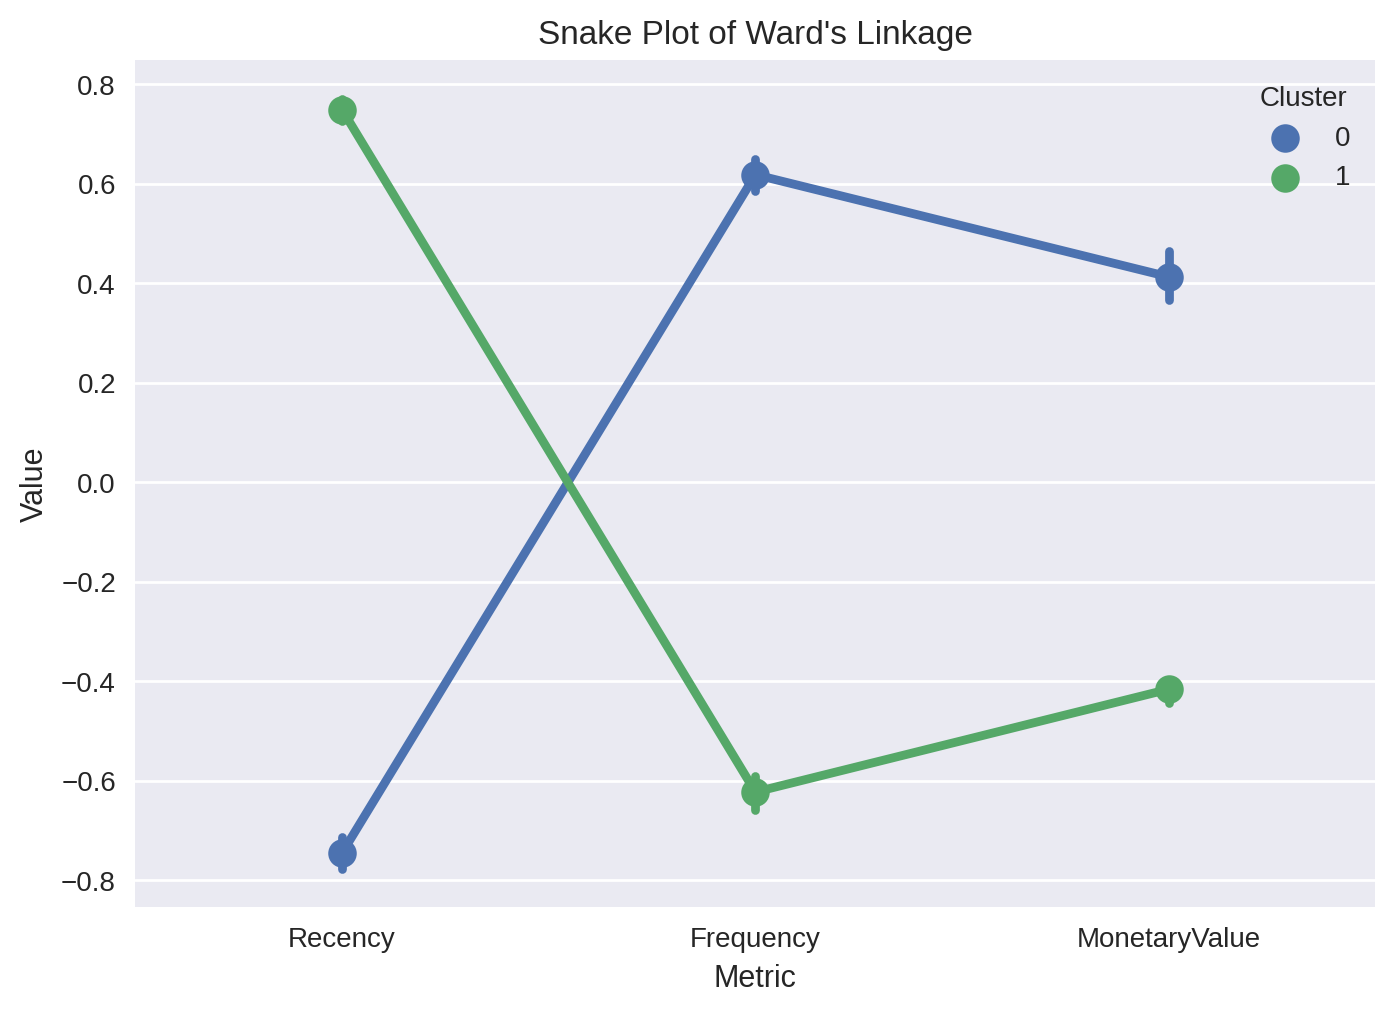

In [34]:
plt.title('Snake Plot of Ward\'s Linkage')
snake_plot(df_rfm_normal, df_rfm_W, df_rfm)

# Relative Importance of Segment Attributes

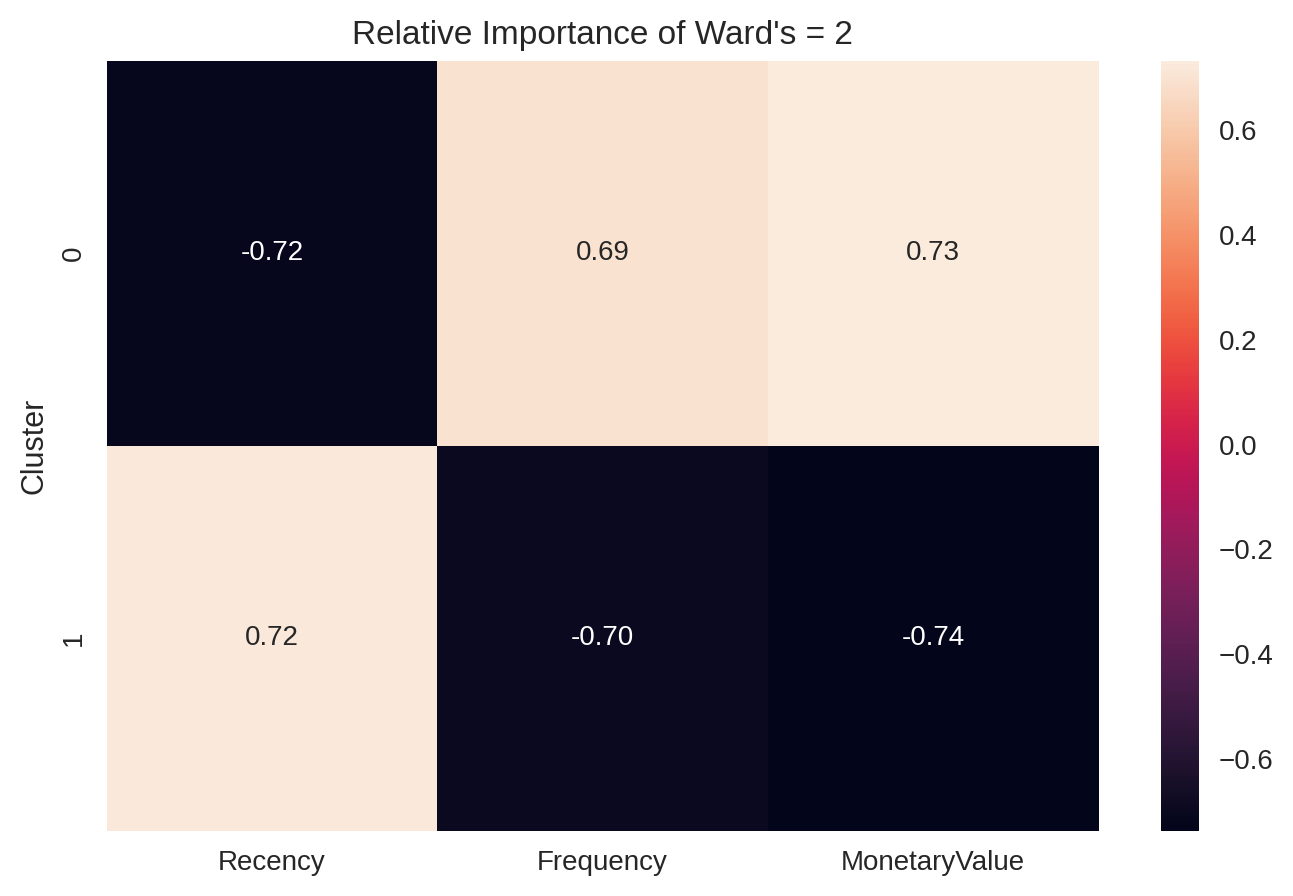

In [35]:
plt.figure(figsize=(8, 5))

plt.title('Relative Importance of Ward\'s = 2')
relative_importance(df_rfm_W, df_rfm)

# EM clustering (Expectation-Maximization clustering) 

In [36]:
def check_em_cluster(dataset, start=2, end=11):
    '''
    Calculate the optimal number of ggm
    
    INPUT:
        dataset : dataframe. Dataset for ggm to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values of bic and aic 
       
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
   
    bic_scores = []
    aic_scores=[]

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        gmm = GaussianMixture(n_components=n_clusters)
        labels = gmm.fit_predict(dataset)

        # Calcualte model performance
       
        bic_=round(gmm.bic(dataset),2)
        aic_=round(gmm.aic(dataset),2)
        # Append score to lists
       
        n_clu.append(n_clusters)
        bic_scores.append(bic_)
        aic_scores.append(aic_)

        print("No. Clusters: {},  BIC: {}  , AIC: {}".format(
            n_clusters, bic_scores[-1],aic_scores[-1] ))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(9,6))

            plt.subplot(2, 1, 1)
            plt.title('BIC Scores')
            sns.pointplot(x=n_clu, y=bic_scores)

            plt.subplot(2, 1, 2)
            plt.title('AIC Scores')
            sns.pointplot(x=n_clu, y=aic_scores)
            plt.tight_layout()
            plt.show()
            

No. Clusters: 2,  BIC: 27190.76  , AIC: 27069.83
No. Clusters: 3,  BIC: 25245.98  , AIC: 25061.39
No. Clusters: 4,  BIC: 24723.39  , AIC: 24475.15
No. Clusters: 5,  BIC: 24539.04  , AIC: 24227.15
No. Clusters: 6,  BIC: 24038.95  , AIC: 23663.4
No. Clusters: 7,  BIC: 24242.8  , AIC: 23803.6
No. Clusters: 8,  BIC: 23851.04  , AIC: 23348.19
No. Clusters: 9,  BIC: 23542.27  , AIC: 22975.77
No. Clusters: 10,  BIC: 23566.27  , AIC: 22936.11


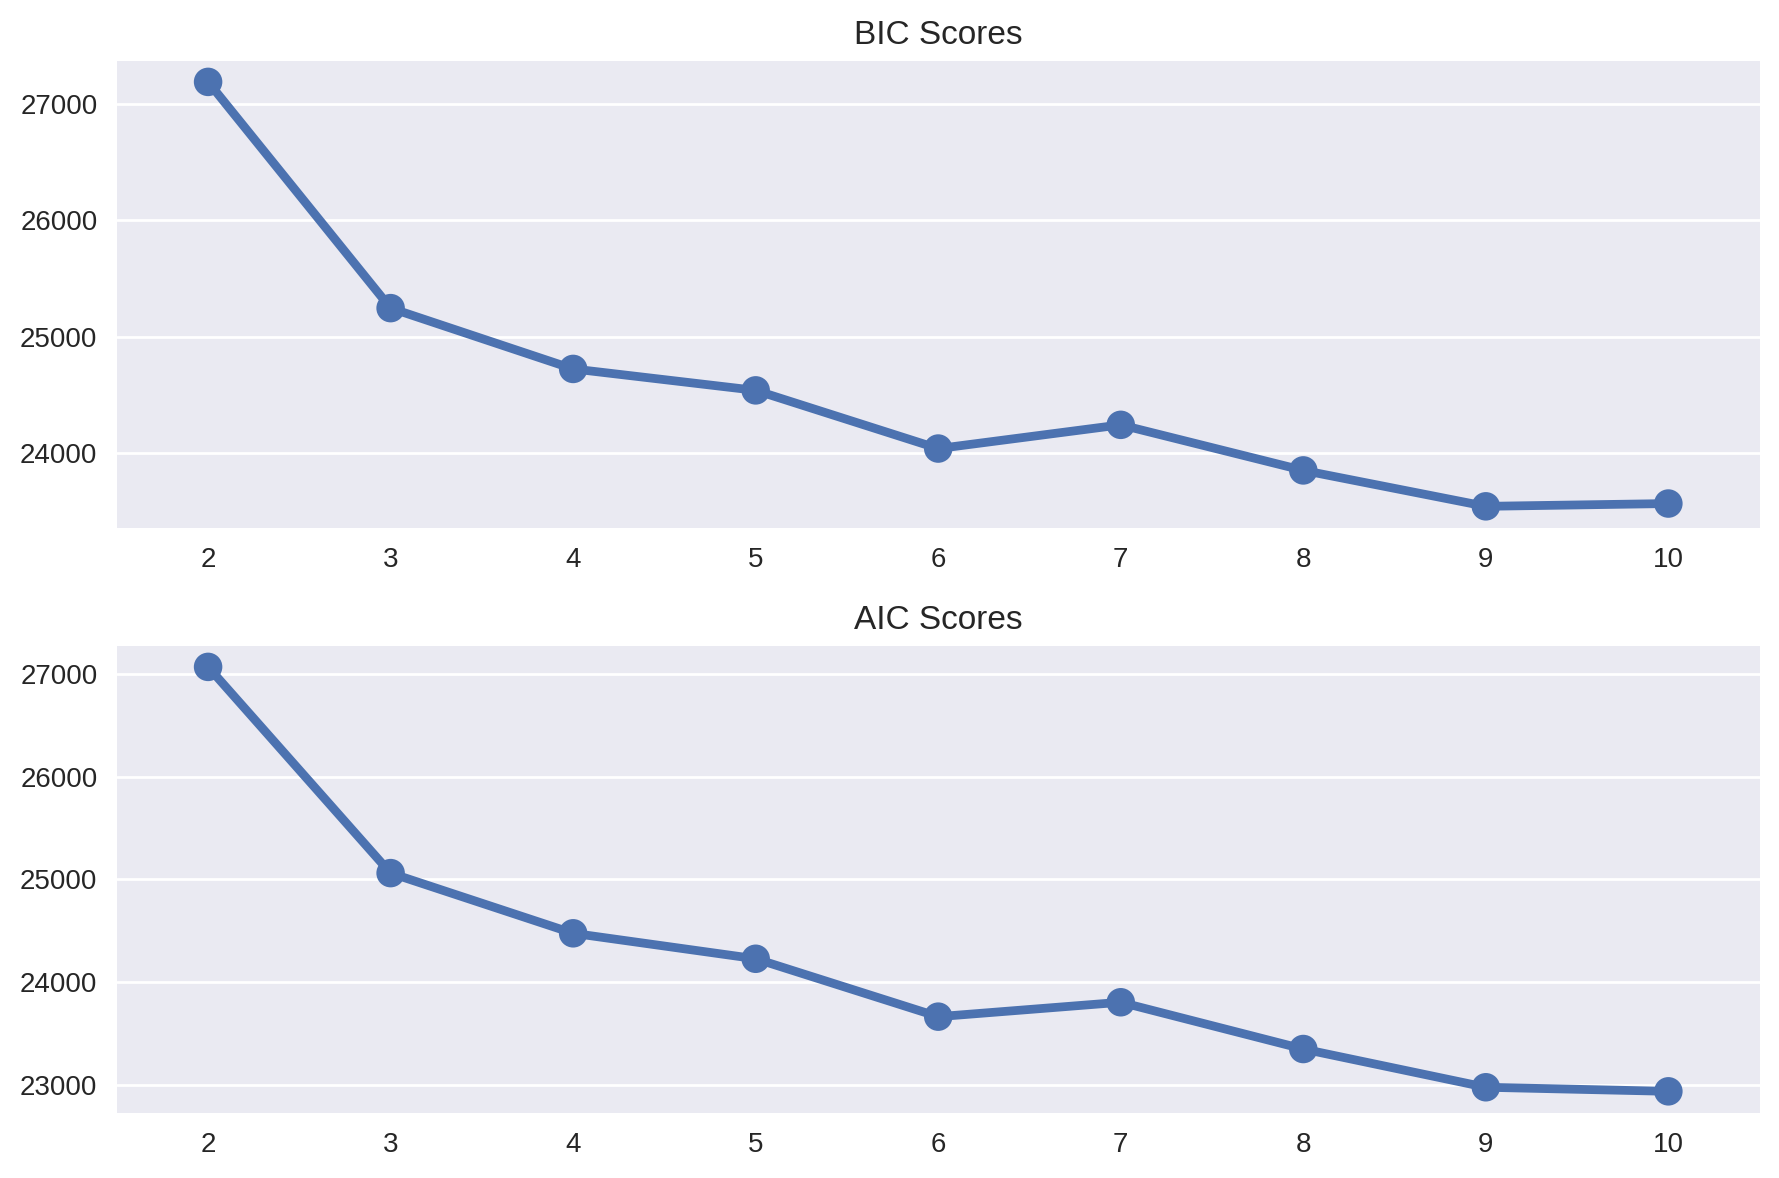

In [37]:
check_em_cluster(df_rfm_normal)

In [38]:
def em_cluster(normalised_df_rfm, clusters_number, original_df_rfm):
    '''
    Implement em clustering on dataset
    
    INPUT:
        normalised_df_rfm : dataframe. Normalised rfm dataset for em to fit.
        clusters_number : int. Number of clusters to form.
        original_df_rfm : dataframe. Original rfm dataset to assign the labels to.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''
    
    gmm = GaussianMixture(n_components=clusters_number, random_state = 1)
    gmm.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = gmm.predict(normalised_df_rfm)
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

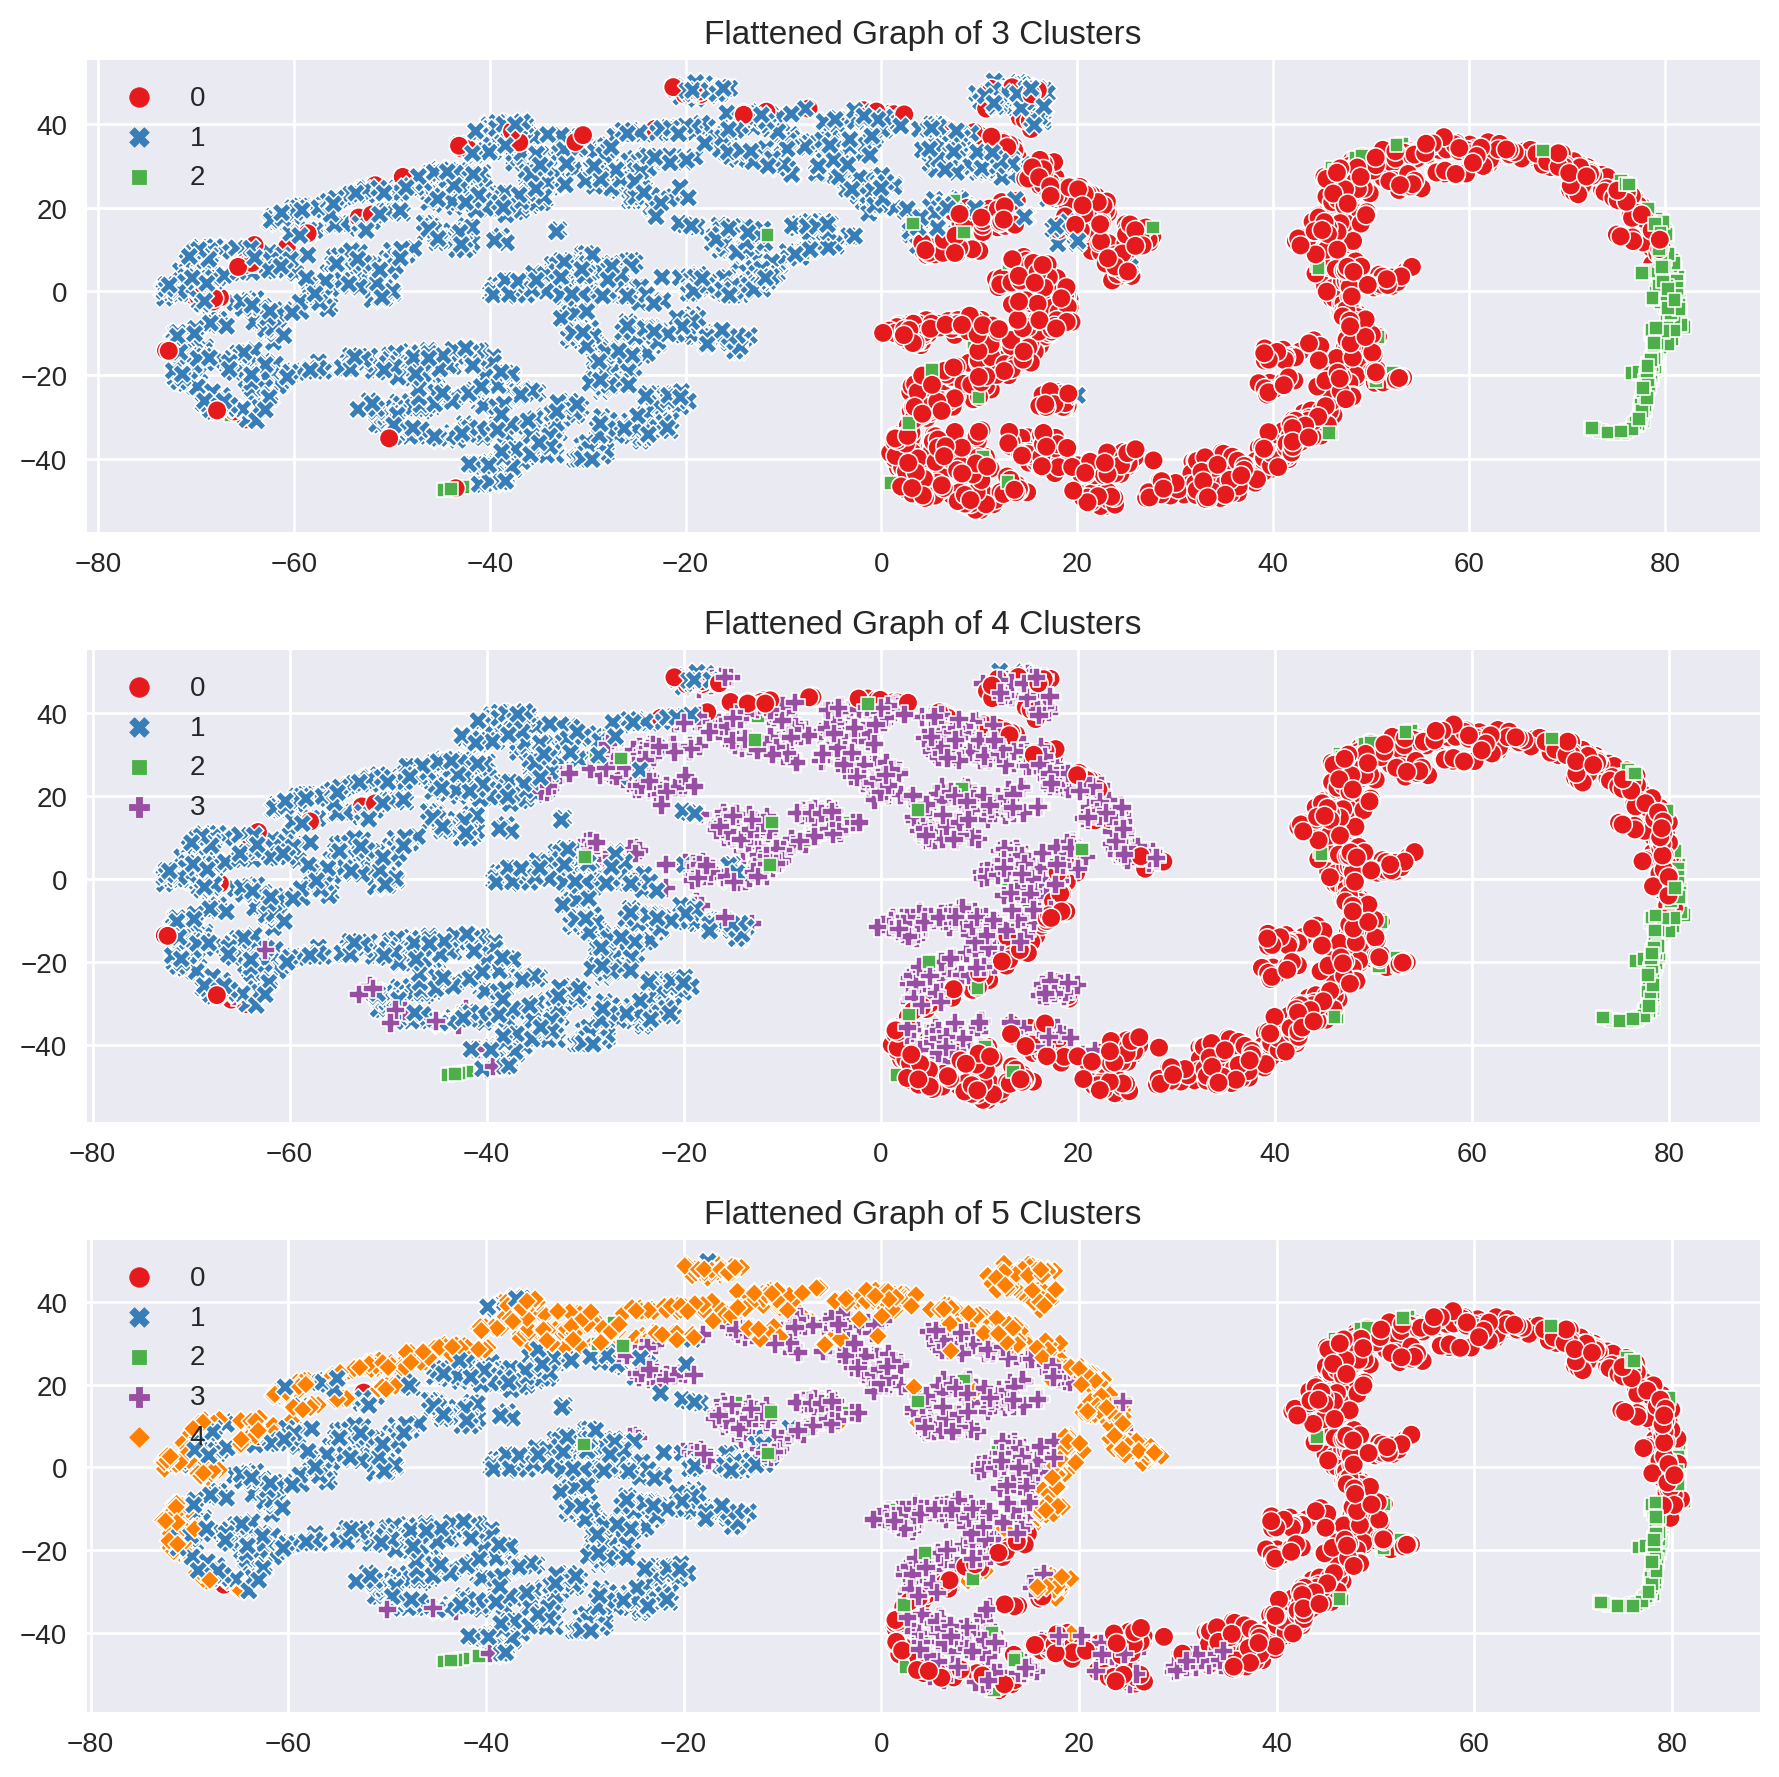

In [39]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
df_rfm_e3 = em_cluster(df_rfm_normal, 3, df_rfm)

plt.subplot(3, 1, 2)
df_rfm_e4 = em_cluster(df_rfm_normal, 4, df_rfm)

plt.subplot(3, 1, 3)
df_rfm_e5 = em_cluster(df_rfm_normal, 5, df_rfm)

plt.tight_layout()
plt.savefig('flattened.png', format='png', dpi=1000)

## Silhouette plot for 3 Cluster Solution

Cluster 0 avg silhouette: 0.23162524550037983
Cluster 1 avg silhouette: 0.31516677765563994
Cluster 2 avg silhouette: -0.07191074785783039
Total avg silhouette: 0.25340880883944816


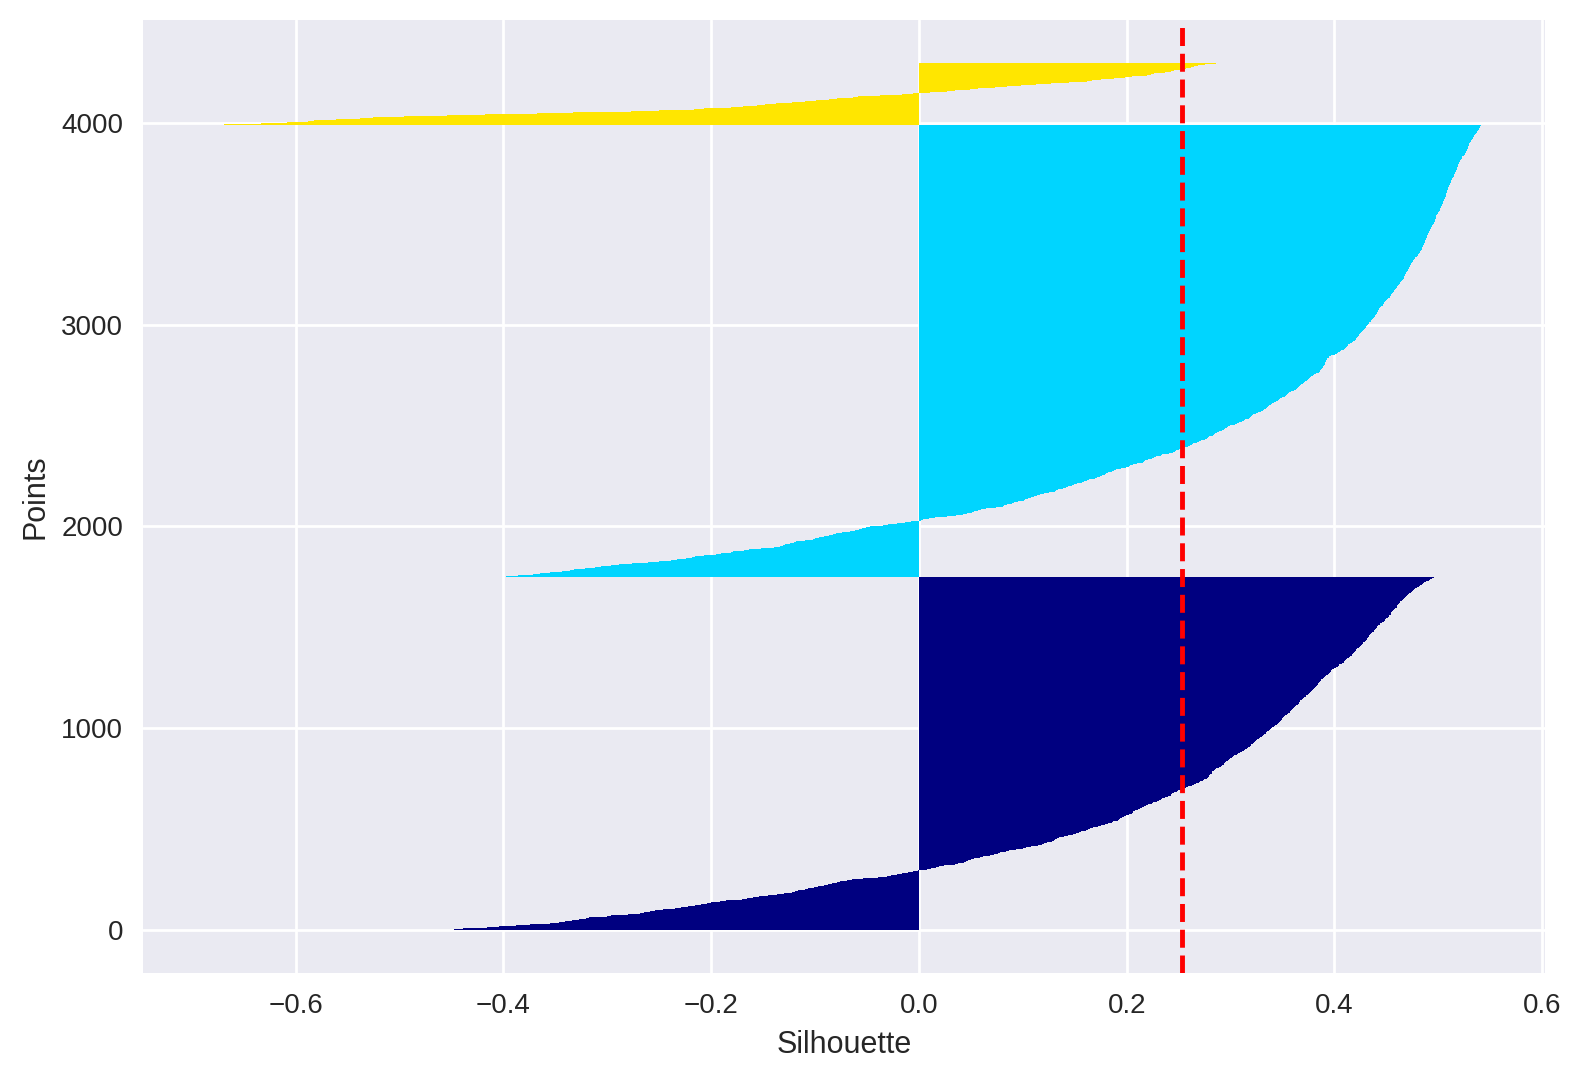

In [40]:
plot_silhouette_score(df_rfm_normal, df_rfm_e3['Cluster'])

## Silhouette plot for 4 Cluster Solution

Cluster 0 avg silhouette: 0.15777374607864875
Cluster 1 avg silhouette: 0.021759660144356485
Cluster 2 avg silhouette: -0.20064318160329658
Cluster 3 avg silhouette: 0.2196799527925167
Total avg silhouette: 0.10744301843112017


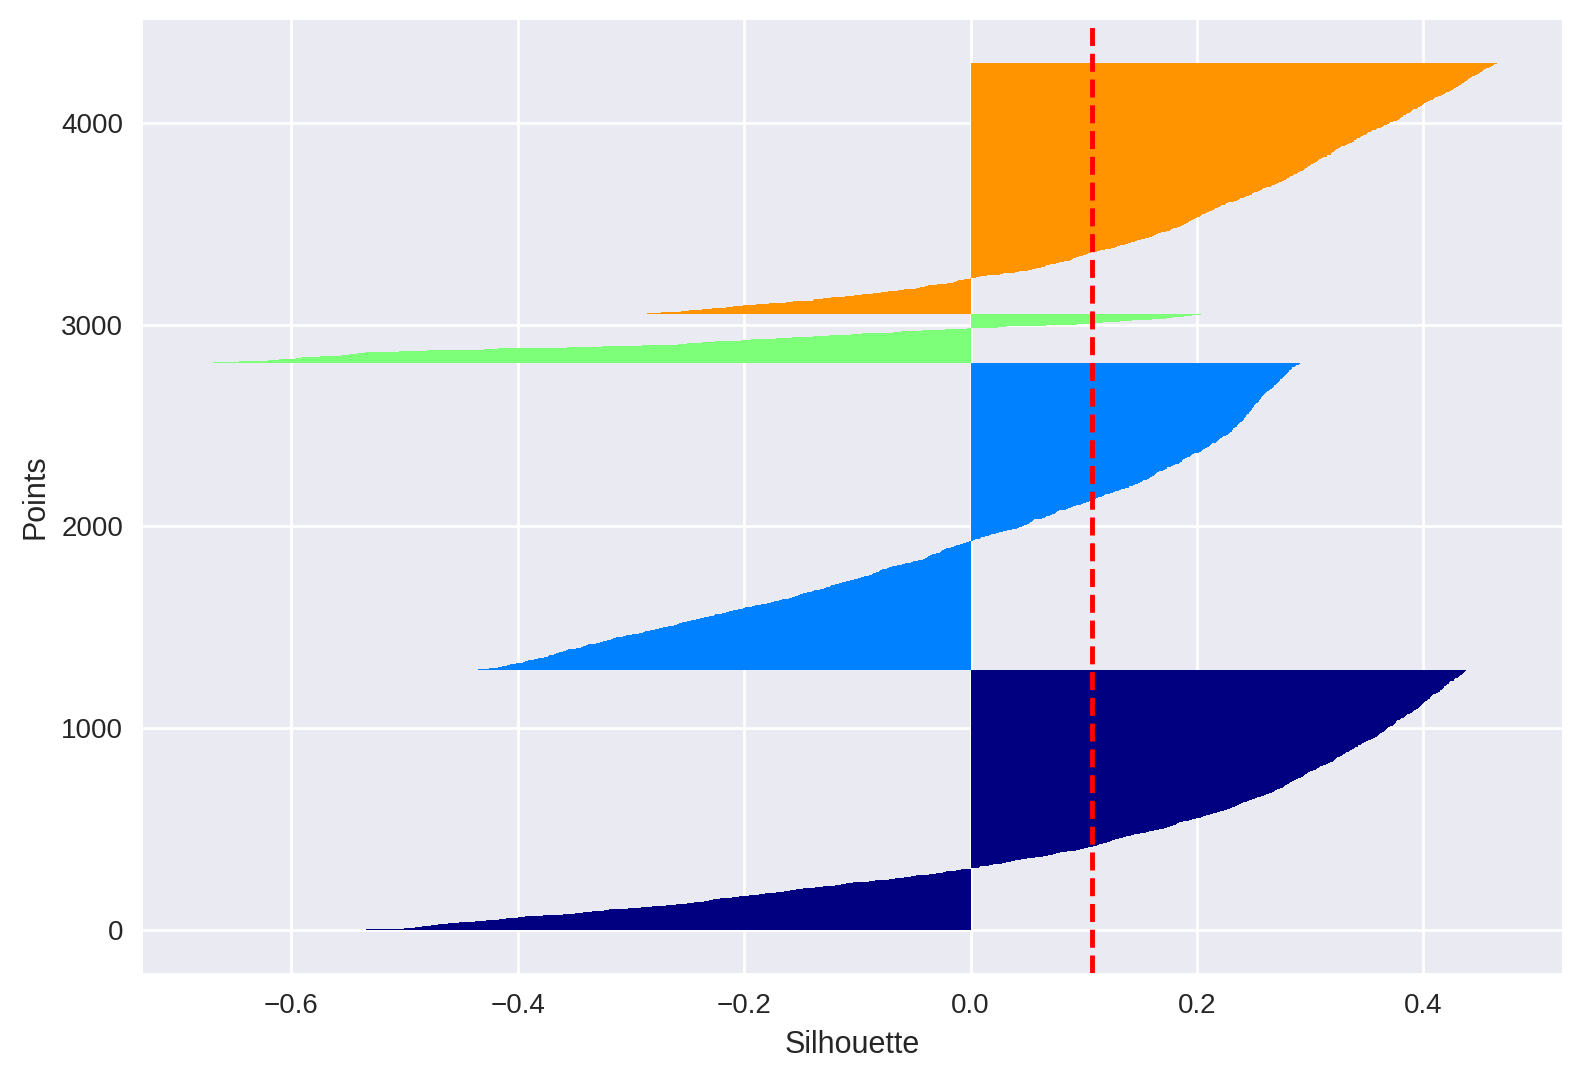

In [41]:
plot_silhouette_score(df_rfm_normal, df_rfm_e4['Cluster'])

## Silhouette plot for 5 Cluster Solution

Cluster 0 avg silhouette: 0.13371110494984412
Cluster 1 avg silhouette: 0.11429676489823469
Cluster 2 avg silhouette: -0.2732773287136178
Cluster 3 avg silhouette: 0.24870698693404783
Cluster 4 avg silhouette: 0.1287021348447678
Total avg silhouette: 0.12876687732434364


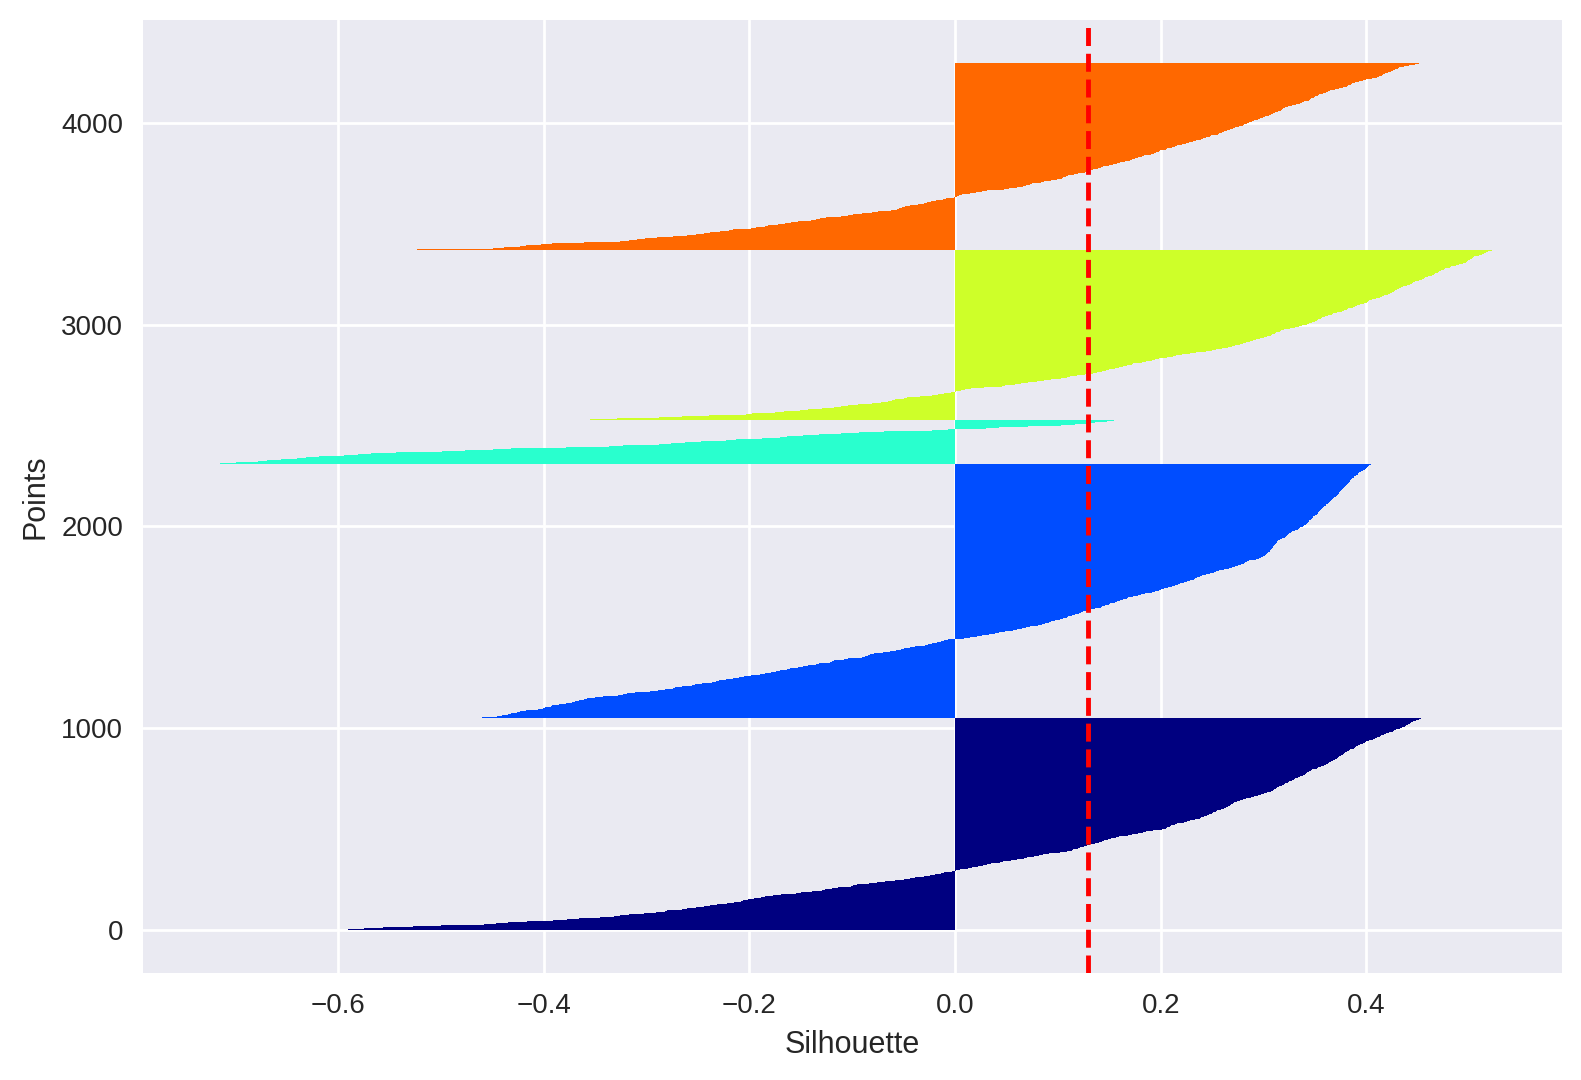

In [42]:
plot_silhouette_score(df_rfm_normal, df_rfm_e5['Cluster'])

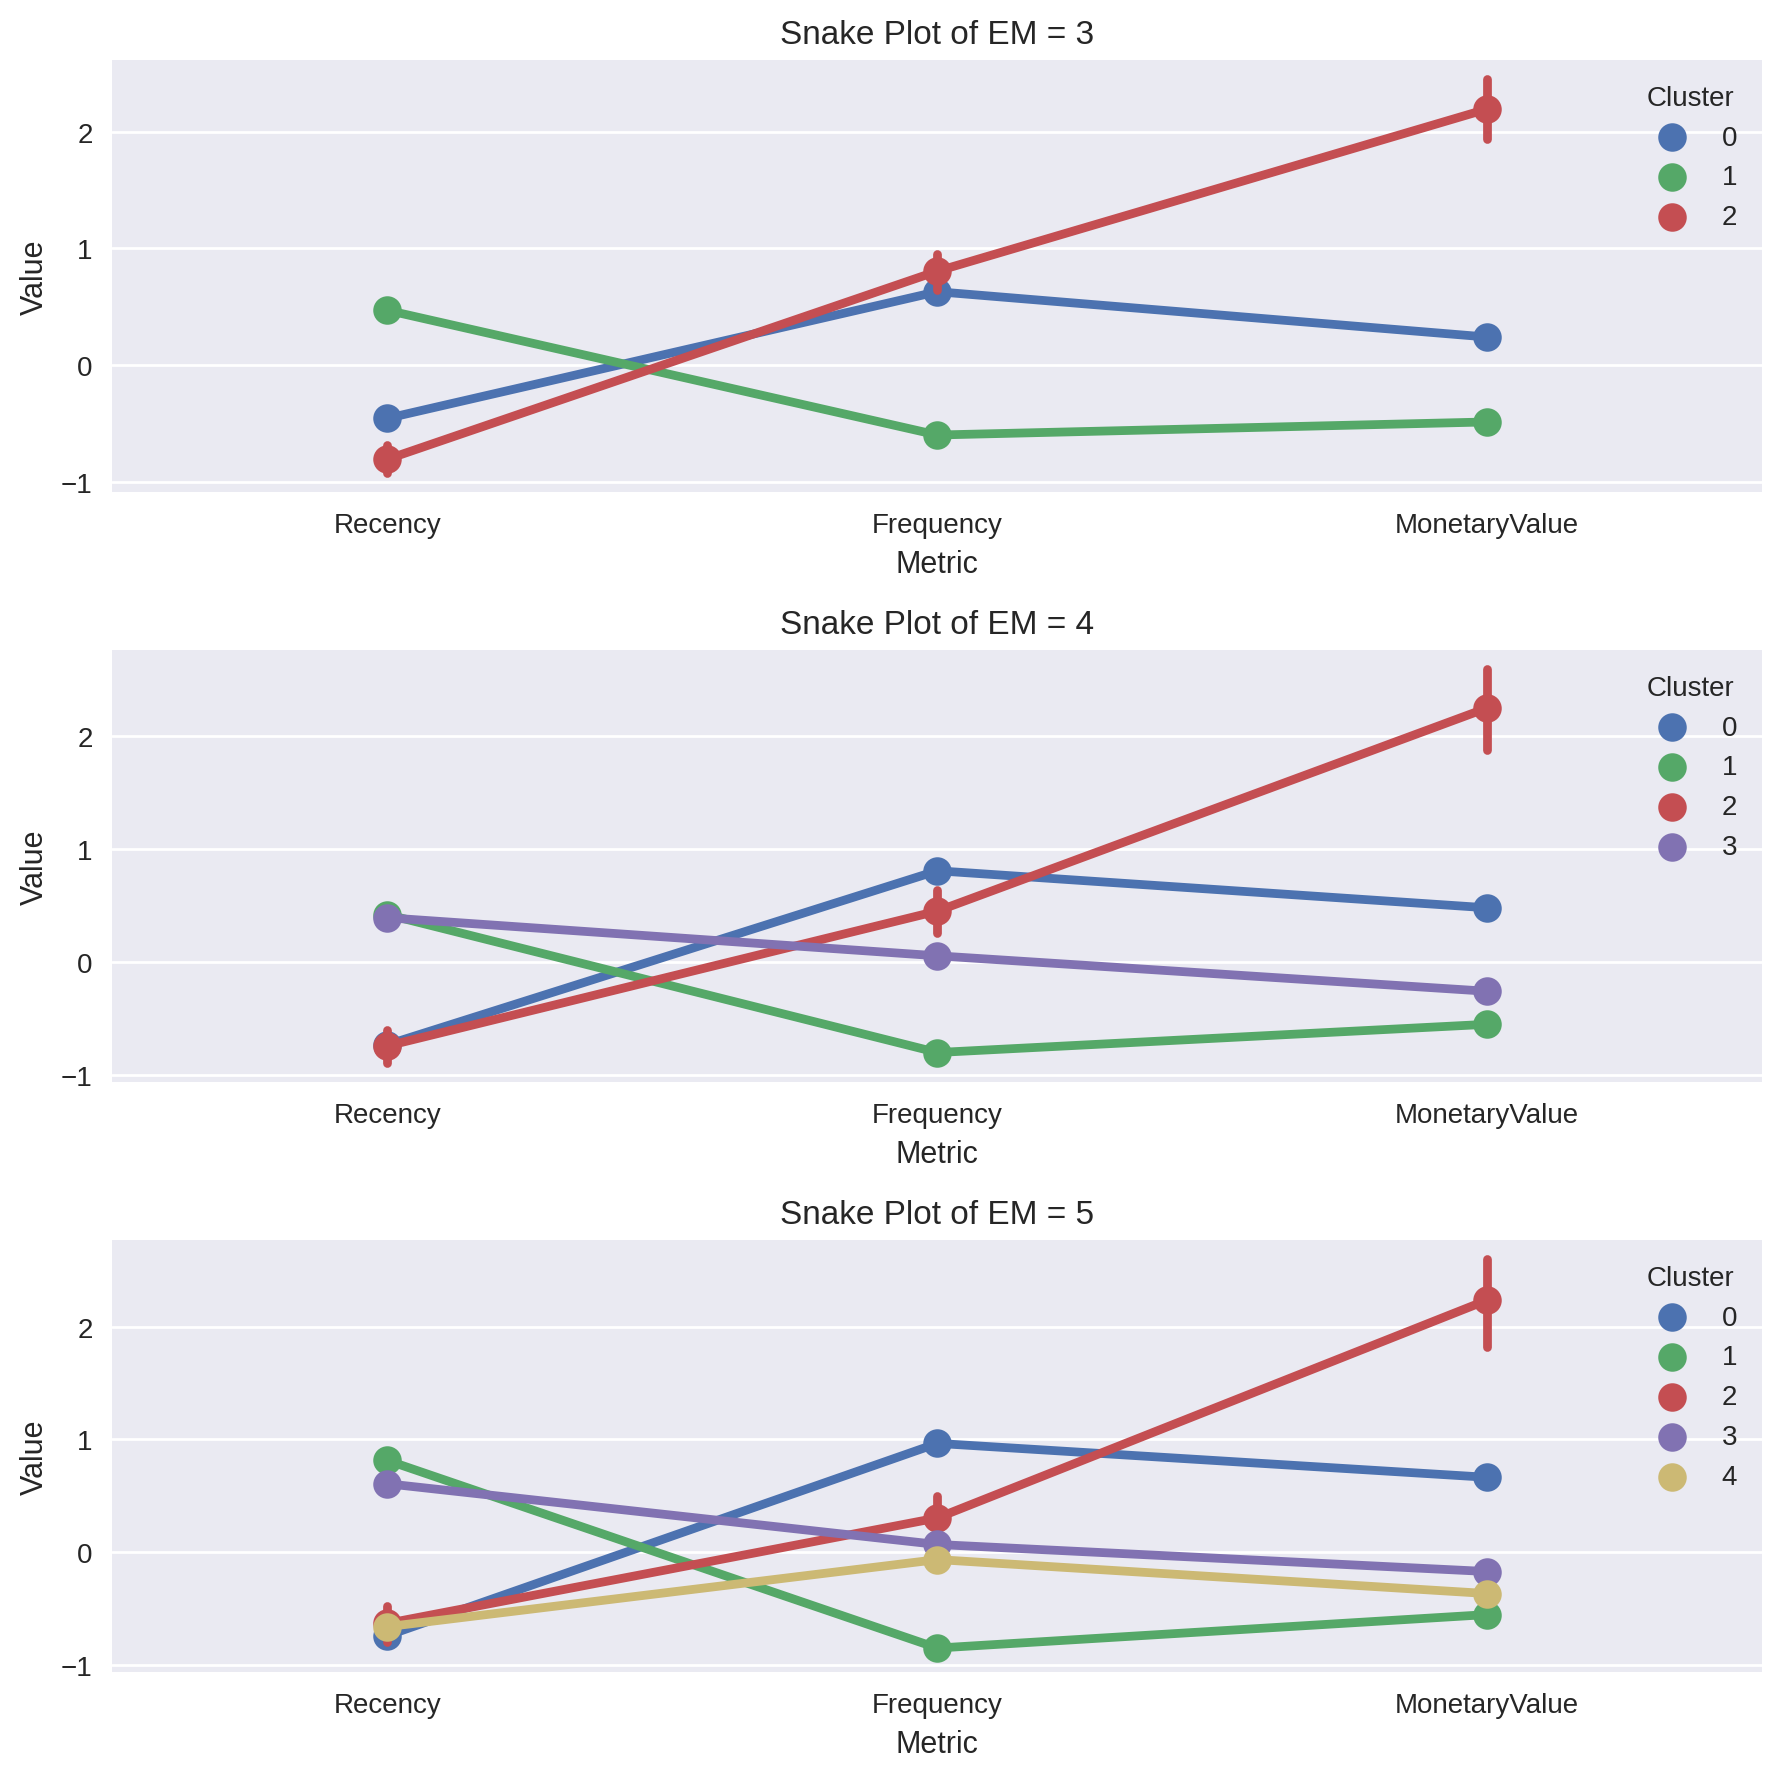

In [43]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of EM = 3')
snake_plot(df_rfm_normal, df_rfm_e3, df_rfm)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of EM = 4')
snake_plot(df_rfm_normal, df_rfm_e4, df_rfm)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of EM = 5')
snake_plot(df_rfm_normal, df_rfm_e5, df_rfm)

plt.tight_layout()

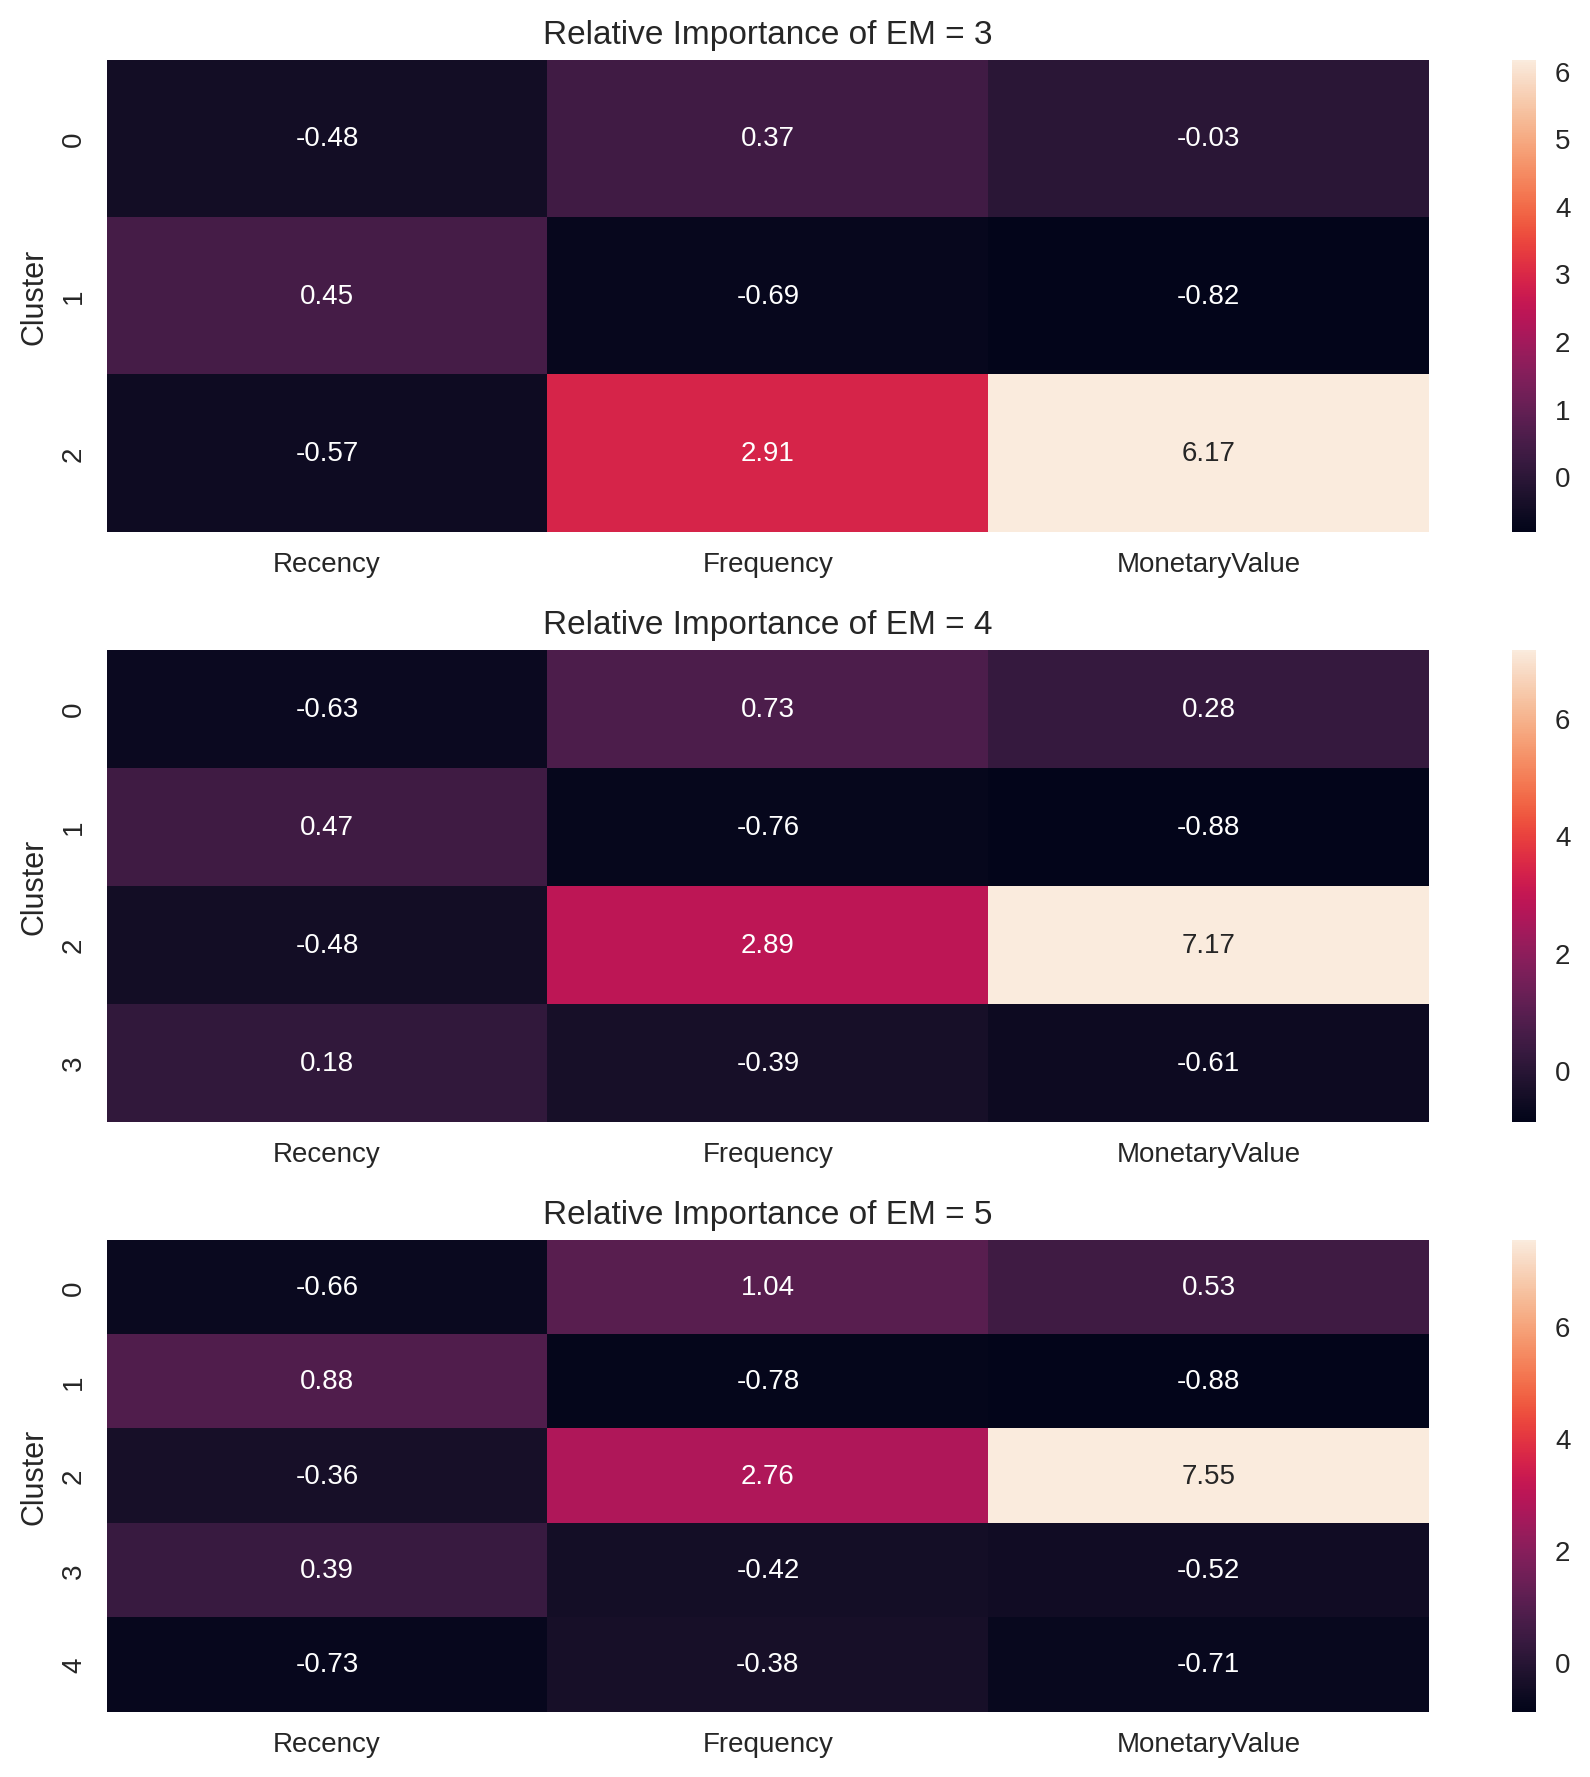

In [44]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Relative Importance of EM = 3')
relative_importance(df_rfm_e3, df_rfm)

plt.subplot(3, 1, 2)
plt.title('Relative Importance of EM = 4')
relative_importance(df_rfm_e4, df_rfm)

plt.subplot(3, 1, 3)
plt.title('Relative Importance of EM = 5')
relative_importance(df_rfm_e5, df_rfm)

plt.tight_layout()

In [46]:
customer_profile_kmeans = df_rfm_k3.copy(deep=True)
customer_profile_kmeans['Cluster'] = customer_profile_kmeans['Cluster'].map({0: 'high', 1: 'low', 2: 'medium'}) # check clusters-labels mapping for each run!
customer_profile_kmeans.head()


Recency  Frequency  MonetaryValue Cluster
CustomerID                                           
12346.0         326          2           0.00     low
12347.0           3        151        3598.21    high
12348.0          76         31        1797.24     low
12349.0          19         73        1757.55  medium
12350.0         311         17         334.40     low

In [47]:

customer_profile_kmeans.to_csv('customer_profile_kmeans.csv')